<a href="https://colab.research.google.com/github/varisvithitpaiboon/Proactive-Customer-Experience-Management-Using-Predictive-Analytics-on-WiFi-Behavior-Data/blob/main/UCL_Lifemote_Predictive_Maintenance_Final_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import library

In [ ]:
!pip -q install optuna
!pip -q install catboost
!pip -q install tsfresh[dask]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 24.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import os
from datetime import timedelta
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from collections import Counter
from sklearn.metrics import (roc_auc_score, average_precision_score, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve)
from sklearn.model_selection import cross_val_score
import optuna
import shap
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
import IPython.display as display
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import gc
import tsfresh
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import EfficientFCParameters
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters
from sklearn.feature_selection import SelectFromModel
from collections import Counter
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc
import lightgbm as lgb
from tqdm import tqdm

# Import data from google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Network Data

In [ ]:
# Set your folder path inside Google Drive
network_folder_path = '/content/drive/MyDrive/UCL-Lifemote/network_data'
chunksize = 50000  # Adjust based on available RAM

# List all CSV files in the folder
network_csv_files = [f for f in os.listdir(network_folder_path) if f.endswith('.csv')]

# Initialize an empty list to collect all chunks
dataframes = []

# Process files in chunks
for file in tqdm(network_csv_files, desc="Processing CSV files"):
    full_path = os.path.join(network_folder_path, file)
    try:
        chunk_iter = pd.read_csv(full_path, chunksize=chunksize)
        for i, chunk in enumerate(chunk_iter):
            chunk['source_file'] = file  # Optional: tag origin
            chunk['chunk_number'] = i    # Optional: track chunk
            dataframes.append(chunk)     # Store each chunk temporarily
    except Exception as e:
        print(f" Failed to load {file}: {e}")

# Combine all chunks into one DataFrame
if dataframes:
    df_network = pd.concat(dataframes, ignore_index=True)
    print(f" Final df_network shape: {df_network.shape}")
else:
    print(" No valid data was read from the folder.")


Processing CSV files: 100%|██████████| 30/30 [01:20<00:00,  2.67s/it]


 Final df_network shape: (13605240, 96)


# Data Preprocessing

In [ ]:
# assume df_network is your target and df holds the wifi_qoe_status column

# 1) Identify “poor” vs “empty” rows
is_poor  = df_network['wifi_qoe_status'].str.lower() == 'poor'
is_empty = df_network['wifi_qoe_status'].isna() | (df_network['wifi_qoe_status'] == np.nan)

# 2) Build a nullable integer column, defaulting to NA
df_network['flag_fault'] = pd.Series(pd.NA, index=df_network.index, dtype="Int64")

# 3) Fill in 1 for “poor”
df_network.loc[is_poor, 'flag_fault'] = 1

# 4) Fill in 0 for all other non-empty, non-poor rows
df_network.loc[~is_poor & ~is_empty, 'flag_fault'] = 0

df_network.tail()

,device_id,analysis_date,id,analysis_id,reboots,script_boots,ap_count,total_samples_24,total_samples_5,good_samples_24,...,poor_iot_weighted_samples_24,poor_active_iot_weighted_samples_24,channel_changes_count_24,channel_changes_count_5,channel_changes_count_6,mem_usage,high_mem_usage_samples,source_file,chunk_number,flag_fault
13605235,DEVICE_ID_12ca7ad469,2025-07-10 00:00:00,ID_6012931456,ANALYSIS_ID_dfd92999b1,0,0,0,1439,2814,1438,...,0,0,0.0,0.0,NaN,56.81,0,cpe_status_2025-07-10_ready.csv,9,0
13605236,DEVICE_ID_8c73fd16b2,2025-07-10 00:00:00,ID_0dd30f864f,ANALYSIS_ID_ad3cdb02a5,0,0,1,294,5817,238,...,18,0,0.0,0.0,NaN,21.37,0,cpe_status_2025-07-10_ready.csv,9,0
13605237,DEVICE_ID_2871b13069,2025-07-10 00:00:00,ID_71dce99f39,ANALYSIS_ID_3c0dcab5a1,0,0,0,3828,7620,3677,...,17,1,0.0,0.0,NaN,42.78,0,cpe_status_2025-07-10_ready.csv,9,0
13605238,DEVICE_ID_fc95d7b1b2,2025-07-10 00:00:00,ID_d3f1eb691a,ANALYSIS_ID_2cff5e191d,0,0,1,806,4165,750,...,9,0,0.0,0.0,NaN,26.22,0,cpe_status_2025-07-10_ready.csv,9,0
13605239,DEVICE_ID_51ae5b2c14,2025-07-10 00:00:00,ID_4952d7cd0e,ANALYSIS_ID_2ed609e0a6,0,0,0,176,0,101,...,13,0,0.0,0.0,NaN,22.25,0,cpe_status_2025-07-10_ready.csv,9,<NA>


In [ ]:
print(df_network['wifi_qoe_status'].unique())
print(df_network['wifi_qoe_status'].value_counts(dropna=False))

['POOR' 'GOOD' 'MID' nan]
wifi_qoe_status
GOOD    9007098
POOR    1837482
MID     1566103
NaN     1194557
Name: count, dtype: int64


In [ ]:
df_merged = df_network

del df_network

gc.collect()

20552

In [ ]:
df_merged.tail()

,device_id,analysis_date,id,analysis_id,reboots,script_boots,ap_count,total_samples_24,total_samples_5,good_samples_24,...,poor_iot_weighted_samples_24,poor_active_iot_weighted_samples_24,channel_changes_count_24,channel_changes_count_5,channel_changes_count_6,mem_usage,high_mem_usage_samples,source_file,chunk_number,flag_fault
13605235,DEVICE_ID_12ca7ad469,2025-07-10 00:00:00,ID_6012931456,ANALYSIS_ID_dfd92999b1,0,0,0,1439,2814,1438,...,0,0,0.0,0.0,NaN,56.81,0,cpe_status_2025-07-10_ready.csv,9,0
13605236,DEVICE_ID_8c73fd16b2,2025-07-10 00:00:00,ID_0dd30f864f,ANALYSIS_ID_ad3cdb02a5,0,0,1,294,5817,238,...,18,0,0.0,0.0,NaN,21.37,0,cpe_status_2025-07-10_ready.csv,9,0
13605237,DEVICE_ID_2871b13069,2025-07-10 00:00:00,ID_71dce99f39,ANALYSIS_ID_3c0dcab5a1,0,0,0,3828,7620,3677,...,17,1,0.0,0.0,NaN,42.78,0,cpe_status_2025-07-10_ready.csv,9,0
13605238,DEVICE_ID_fc95d7b1b2,2025-07-10 00:00:00,ID_d3f1eb691a,ANALYSIS_ID_2cff5e191d,0,0,1,806,4165,750,...,9,0,0.0,0.0,NaN,26.22,0,cpe_status_2025-07-10_ready.csv,9,0
13605239,DEVICE_ID_51ae5b2c14,2025-07-10 00:00:00,ID_4952d7cd0e,ANALYSIS_ID_2ed609e0a6,0,0,0,176,0,101,...,13,0,0.0,0.0,NaN,22.25,0,cpe_status_2025-07-10_ready.csv,9,<NA>


In [ ]:
df_merged.shape

(13605240, 97)

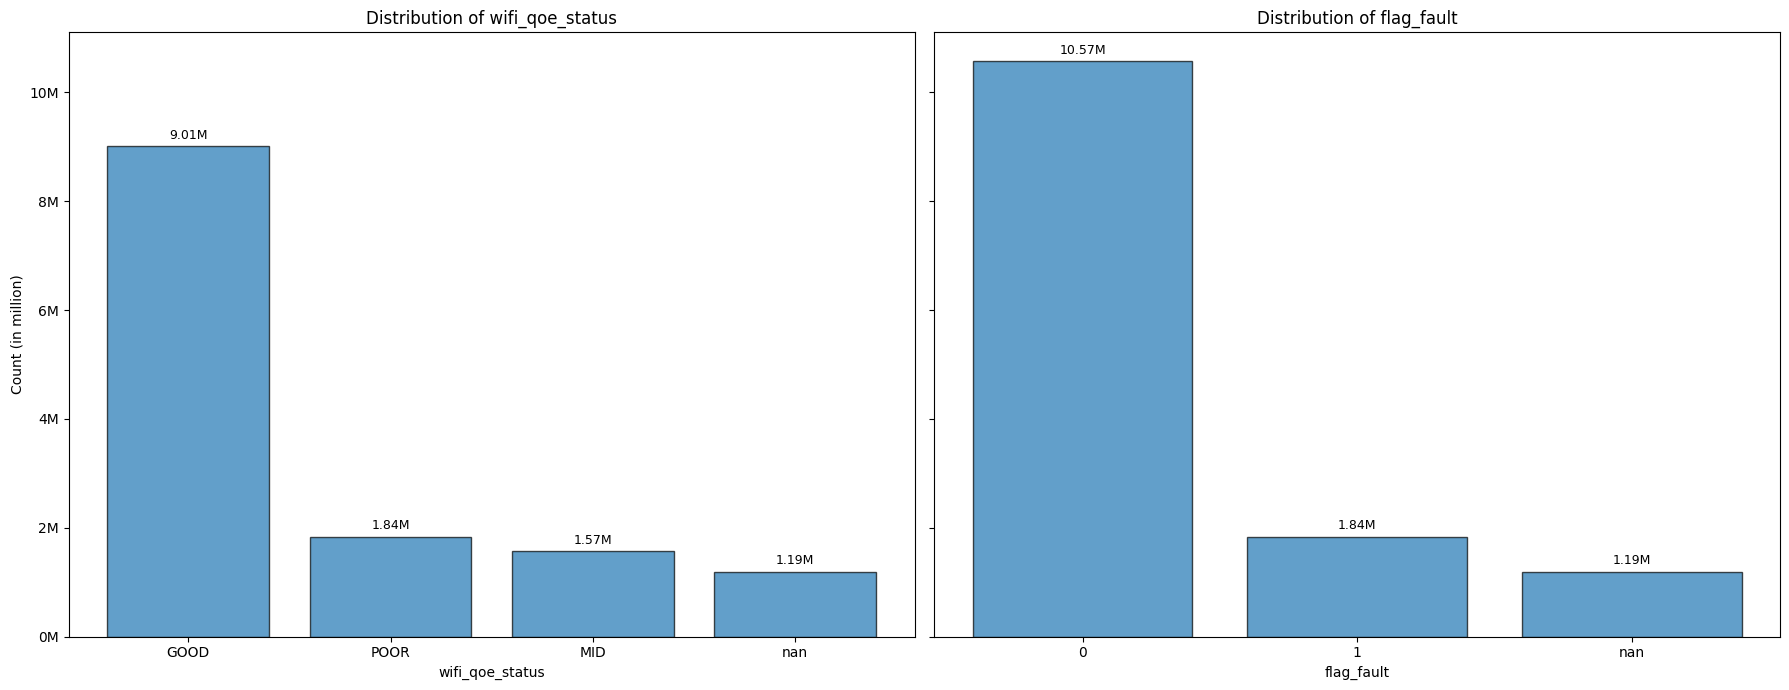

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import FuncFormatter

# === Helper to count including NaNs and format index ===
def count_with_empty(series):
    counts = (
        series
        .replace('', np.nan)
        .value_counts(dropna=False)
    )
    def fmt(x):
        if pd.isna(x):
            return "nan"
        if isinstance(x, float) and x.is_integer():
            return str(int(x))
        return str(x)
    counts.index = counts.index.map(fmt)
    return counts

# === Build each count series ===
qoe_counts   = count_with_empty(df_merged['wifi_qoe_status'])
fault_counts = count_with_empty(df_merged['flag_fault'])

# === Plot ===
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7), sharey=True)

def plot_with_labels(ax, data, title, xlabel):
    bars = ax.bar(data.index, data.values, color='#1f77b4', alpha=0.7, edgecolor='black')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.tick_params(axis='x', rotation=0)

    # Format y-axis to show M
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1e6:.0f}M'))

    # Bar labels in millions
    ax.bar_label(
        bars,
        labels=[f"{v/1e6:.2f}M" for v in data.values],
        padding=3,
        fontsize=9
    )

plot_with_labels(axes[0], qoe_counts,   "Distribution of wifi_qoe_status", "wifi_qoe_status")
axes[0].set_ylabel("Count (in million)")

plot_with_labels(axes[1], fault_counts, "Distribution of flag_fault", "flag_fault")

plt.tight_layout()
plt.show()


## Check distribution of original dataset

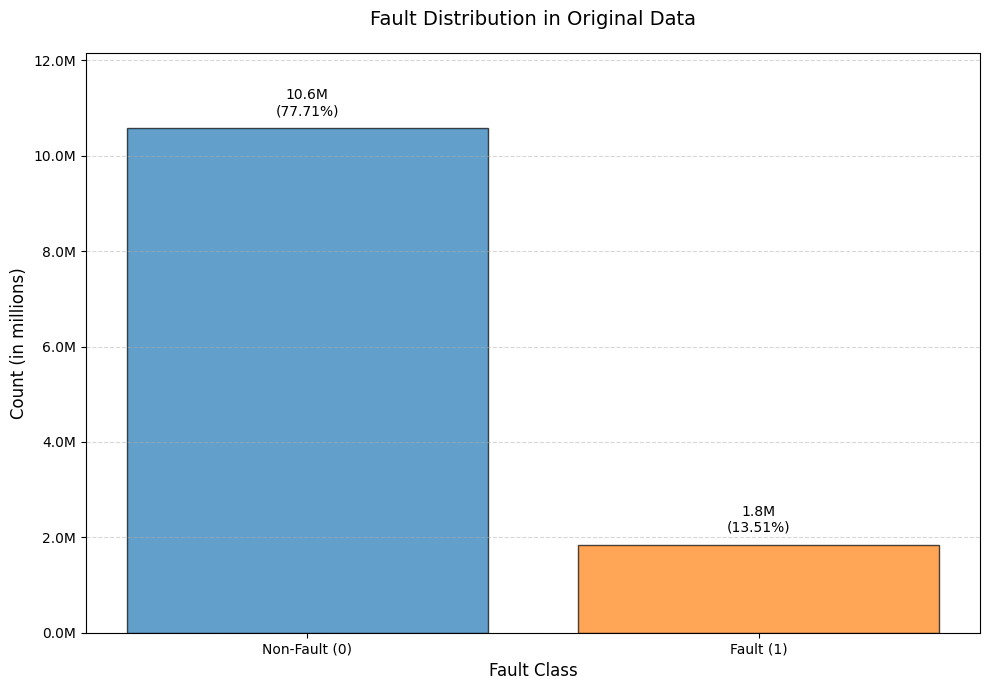

In [ ]:
# Plot for df_merged
counts = df_merged['flag_fault'].value_counts().sort_index()
percentages = (counts / len(df_merged) * 100).round(2)

plt.figure(figsize=(10, 7))
bars = plt.bar(counts.index, counts.values,
               color=['#1f77b4', '#ff7f0e'], alpha=0.7, edgecolor='black')

# Add count and percentage labels (formatted for millions)
for bar, count, percent in zip(bars, counts, percentages):
    height = bar.get_height()
    label = f"{count/1e6:.1f}M\n({percent}%)" if count >= 1e6 else f"{count:,}\n({percent}%)"
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02 * max(counts),
             label,
             ha='center', va='bottom', fontsize=10)

# Customize y-axis to show millions
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'))

plt.title('Fault Distribution in Original Data', pad=20, fontsize=14)
plt.xlabel('Fault Class', fontsize=12)
plt.ylabel('Count (in millions)', fontsize=12)
plt.xticks([0, 1], ['Non-Fault (0)', 'Fault (1)'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.ylim(0, max(counts) * 1.15)

plt.tight_layout()
plt.show()

## Select sample data

In [ ]:
# Select smple data while maintain ratio of orginal classes
def sample_complete_devices(df, target_devices=20_000, fault_col='flag_fault', date_col='analysis_date', random_state=42):
    """
    Samples complete devices while maintaining original fault proportions.

    Args:
        df: Input DataFrame
        target_devices: Number of devices to sample
        fault_col: Fault indicator column name
        date_col: Date column name
        random_state: Random seed for reproducibility

    Returns:
        Sampled DataFrame with complete devices maintaining original fault ratios
    """
    # Calculate original proportions
    original_row_ratio = df[fault_col].mean()
    device_status = df.groupby('device_id')[fault_col].mean().gt(0)
    original_device_ratio = device_status.mean()

    print(f"Original row fault ratio: {original_row_ratio:.5f}")
    print(f"Original device fault ratio: {original_device_ratio:.5f}")

    # Get complete devices (all dates present)
    n_dates = df[date_col].nunique()
    complete_devices = (df.groupby('device_id')[date_col]
                       .nunique()
                       .loc[lambda x: x == n_dates]
                       .index)
    df_complete = df[df['device_id'].isin(complete_devices)]

    # Classify complete devices
    device_status = df_complete.groupby('device_id')[fault_col].mean().gt(0)
    faulty_devices = device_status[device_status].index
    healthy_devices = device_status[~device_status].index

    # Calculate required samples
    n_faulty = int(round(target_devices * original_device_ratio))
    n_faulty = min(n_faulty, len(faulty_devices))
    n_healthy = target_devices - n_faulty

    # Sample devices
    np.random.seed(random_state)
    sampled_faulty = np.random.choice(faulty_devices, n_faulty, replace=False)
    sampled_healthy = np.random.choice(healthy_devices, n_healthy, replace=False)

    # Combine sampled devices
    sampled_devices = np.concatenate([sampled_faulty, sampled_healthy])
    df_sampled = df_complete[df_complete['device_id'].isin(sampled_devices)]  # Consistent naming

    # Calculate scaling factor to match original row ratio
    current_row_ratio = df_sampled[fault_col].mean()
    if current_row_ratio > 0:
        scale_factor = original_row_ratio / current_row_ratio
        if scale_factor < 1:
            # Downsample fault rows
            fault_rows = df_sampled[df_sampled[fault_col] == 1]
            keep_prob = min(scale_factor, 1.0)
            mask = np.random.random(len(fault_rows)) < keep_prob
            df_sampled = pd.concat([
                df_sampled[df_sampled[fault_col] == 0],
                fault_rows[mask]
            ])

    # Verification
    verification = {
        'total_devices': df_sampled['device_id'].nunique(),
        'faulty_devices': len(sampled_faulty),
        'row_fault_ratio': df_sampled[fault_col].mean(),
        'device_fault_ratio': (df_sampled.groupby('device_id')[fault_col].mean() > 0).mean(),
        'date_completeness': (df_sampled.groupby('device_id')[date_col].nunique() == n_dates).all(),
        'total_rows': len(df_sampled)
    }

    print("\n=== Results ===")
    print(f"Sampled devices: {verification['total_devices']}")
    print(f"Faulty devices: {verification['faulty_devices']}")
    print(f"Achieved row fault ratio: {verification['row_fault_ratio']:.5f}")
    print(f"Device fault ratio: {verification['device_fault_ratio']:.5f}")
    print(f"All dates present: {verification['date_completeness']}")
    print(f"Total rows: {verification['total_rows']}")

    return df_sampled

# Usage
df_sampled = sample_complete_devices(df_merged)

Original row fault ratio: 0.14806
Original device fault ratio: 0.48528

=== Results ===
Sampled devices: 20000
Faulty devices: 9706
Achieved row fault ratio: 0.14675
Device fault ratio: 0.48530
All dates present: True
Total rows: 600000


## Check distribution of sample dataset

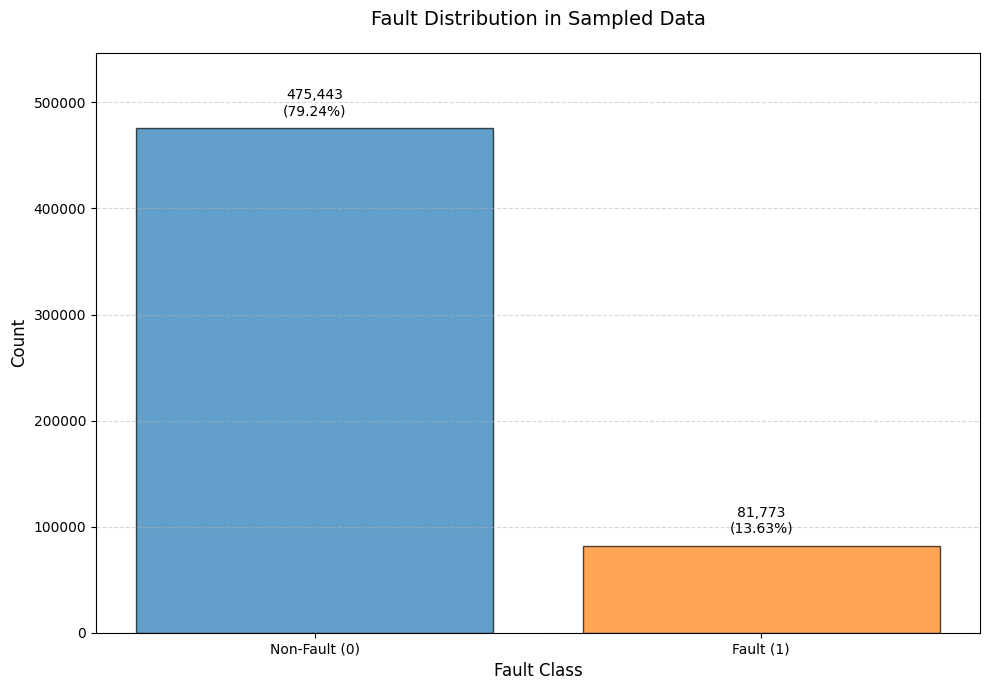

In [ ]:
# Plot for df_sampled
counts = df_sampled['flag_fault'].value_counts().sort_index()
percentages = (counts / len(df_sampled) * 100).round(2)

plt.figure(figsize=(10, 7))
bars = plt.bar(counts.index, counts.values,
               color=['#1f77b4', '#ff7f0e'], alpha=0.7, edgecolor='black')

# Add count and percentage labels
for bar, count, percent in zip(bars, counts, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02 * max(counts),
             f'{count:,}\n({percent}%)',
             ha='center', va='bottom', fontsize=10)

# Customize
plt.title('Fault Distribution in Sampled Data', pad=20, fontsize=14)
plt.xlabel('Fault Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['Non-Fault (0)', 'Fault (1)'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.ylim(0, max(counts) * 1.15)  # Add space for labels

plt.tight_layout()
plt.show()

In [ ]:
# Reassign
df_merged = df_sampled

del df_sampled

gc.collect()

9

In [ ]:
df_merged.head()

,device_id,analysis_date,id,analysis_id,reboots,script_boots,ap_count,total_samples_24,total_samples_5,good_samples_24,...,poor_iot_weighted_samples_24,poor_active_iot_weighted_samples_24,channel_changes_count_24,channel_changes_count_5,channel_changes_count_6,mem_usage,high_mem_usage_samples,source_file,chunk_number,flag_fault
23,DEVICE_ID_3300f681b5,2025-06-11 00:00:00,ID_df72dff685,ANALYSIS_ID_e1af88d602,0,0,0,5062,8158,2479,...,0,0,0.0,0.0,NaN,61.04,0,cpe_status_2025-06-11_ready.csv,0,1
52,DEVICE_ID_9876ae9d0d,2025-06-11 00:00:00,ID_2d9bcbc17c,ANALYSIS_ID_475c5fdf61,0,0,0,10001,11549,2153,...,0,0,0.0,0.0,NaN,63.34,0,cpe_status_2025-06-11_ready.csv,0,0
87,DEVICE_ID_900fa501ba,2025-06-11 00:00:00,ID_4e0c54b543,ANALYSIS_ID_7723f1ce01,0,0,0,1712,260,1364,...,22,1,0.0,0.0,NaN,70.43,0,cpe_status_2025-06-11_ready.csv,0,0
116,DEVICE_ID_782e844448,2025-06-11 00:00:00,ID_01dd8b7ee4,ANALYSIS_ID_0fd120d54e,0,0,1,3435,5710,1813,...,0,0,0.0,0.0,NaN,60.02,0,cpe_status_2025-06-11_ready.csv,0,1
122,DEVICE_ID_00dea9664a,2025-06-11 00:00:00,ID_b624afc682,ANALYSIS_ID_c79381a4cb,0,0,0,49,6179,21,...,8,0,0.0,0.0,NaN,40.62,0,cpe_status_2025-06-11_ready.csv,0,0


In [ ]:
df_merged.shape

(600000, 97)

## Check data type

In [ ]:
# Check data type
df_merged.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Index: 600000 entries, 23 to 13605238
Data columns (total 97 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   device_id                            600000 non-null  object 
 1   analysis_date                        600000 non-null  object 
 2   id                                   600000 non-null  object 
 3   analysis_id                          600000 non-null  object 
 4   reboots                              600000 non-null  int64  
 5   script_boots                         600000 non-null  int64  
 6   ap_count                             600000 non-null  int64  
 7   total_samples_24                     600000 non-null  int64  
 8   total_samples_5                      600000 non-null  int64  
 9   good_samples_24                      600000 non-null  int64  
 10  good_samples_5                       600000 non-null  int64  
 11  poor_qoe_sample

In [ ]:
# Select numerical columns
num_columns = df_merged.select_dtypes(include = 'number').columns
num_columns

Index(['reboots', 'script_boots', 'ap_count', 'total_samples_24',
       'total_samples_5', 'good_samples_24', 'good_samples_5',
       'poor_qoe_samples', 'number_of_wifi_clients', 'cpu_load', 'cpu_temp',
       'free_memory', 'lifemote_cpu_load', 'congested_sample_5_count',
       'congested_sample_active_5_count', 'sample_active_5_count',
       'poor_gw_candidate_rssi_samples_24', 'poor_gw_candidate_rssi_samples_5',
       'rssi_samples_24', 'rssi_samples_5', 'congested_sample_24_count',
       'congested_sample_active_24_count', 'sample_active_24_count',
       'poor_samples_24', 'poor_samples_5', 'good_active_samples_24',
       'good_active_samples_5', 'mid_active_samples_24',
       'mid_active_samples_5', 'mid_samples_24', 'mid_samples_5',
       'poor_active_samples_24', 'poor_active_samples_5',
       'total_active_samples_24', 'total_active_samples_5',
       'uptime_in_minutes', 'dsl_download_bottleneck_count',
       'dsl_upload_bottleneck_count', 'dsl_status',
       'in

## Check Summary Stat

In [ ]:
# Summary Statistic
summary_stats = df_merged[num_columns].describe()
display.display(summary_stats)

,reboots,script_boots,ap_count,total_samples_24,total_samples_5,good_samples_24,good_samples_5,poor_qoe_samples,number_of_wifi_clients,cpu_load,...,mid_fwa_count,poor_iot_weighted_samples_24,poor_active_iot_weighted_samples_24,channel_changes_count_24,channel_changes_count_5,channel_changes_count_6,mem_usage,high_mem_usage_samples,chunk_number,flag_fault
count,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,...,600000.0,600000.000000,600000.000000,599991.000000,599896.000000,0.0,600000.000000,600000.00000,600000.000000,557216.0
mean,0.044080,0.001218,0.037488,2602.521967,4518.453123,1382.708390,3079.431610,50.889687,8.669872,15.011320,...,0.0,32.799013,2.797940,0.084721,0.040847,NaN,52.514418,3.43621,4.038352,0.146753
std,0.395648,0.034883,0.285336,3197.947723,3466.382016,1919.192614,2842.158021,136.269718,5.332150,8.831106,...,0.0,140.867323,16.698245,6.998871,0.392087,NaN,14.126620,67.36781,2.608320,0.35386
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.440000,...,0.0,0.000000,0.000000,0.000000,0.000000,NaN,-60.910000,0.00000,0.000000,0.0
25%,0.000000,0.000000,0.000000,317.000000,1929.000000,81.000000,1065.000000,0.000000,5.000000,7.290000,...,0.0,0.000000,0.000000,0.000000,0.000000,NaN,41.690000,0.00000,2.000000,0.0
50%,0.000000,0.000000,0.000000,1595.000000,3852.000000,760.000000,2308.000000,6.000000,8.000000,14.260000,...,0.0,1.000000,0.000000,0.000000,0.000000,NaN,58.370000,0.00000,4.000000,0.0
75%,0.000000,0.000000,0.000000,3583.000000,6324.000000,1881.000000,4275.000000,37.000000,11.000000,20.600000,...,0.0,10.000000,1.000000,0.000000,0.000000,NaN,62.680000,0.00000,6.000000,0.0
max,77.000000,1.000000,7.000000,75218.000000,34304.000000,45711.000000,32291.000000,5363.000000,148.000000,99.970000,...,0.0,5725.000000,1346.000000,1439.000000,76.000000,NaN,99.160000,1440.00000,9.000000,1.0


## Check Filling Rate

In [ ]:
# Calculate percentage of non-null values for each column
filling_rates = 100 * df_merged.count() / df_merged.shape[0]

# Round to 2 decimal places
filling_rates = filling_rates.round(2)

# Filter and sort columns with less than 100% filled
incomplete_columns = filling_rates[filling_rates < 100].sort_values(ascending=True)

# Print the result
if not incomplete_columns.empty:
    print(f"Columns with less than 100% non-null values (ascending): {len(incomplete_columns)}")
else:
    print("All columns are 100% complete.")

Columns with less than 100% non-null values (ascending): 23


In [ ]:
# Calculate percentage of non-null values for each column
filling_rates = 100 * df_merged.count() / df_merged.shape[0]

# Round to 2 decimal places
filling_rates = filling_rates.round(2)

# Filter and sort columns with less than 100% filled
incomplete_columns = filling_rates[filling_rates < 100].sort_values(ascending=True)

# Print the result
if not incomplete_columns.empty:
    print(f"Columns with less than 100% non-null values (ascending): {len(incomplete_columns)}")
else:
    print("All columns are 100% complete.")

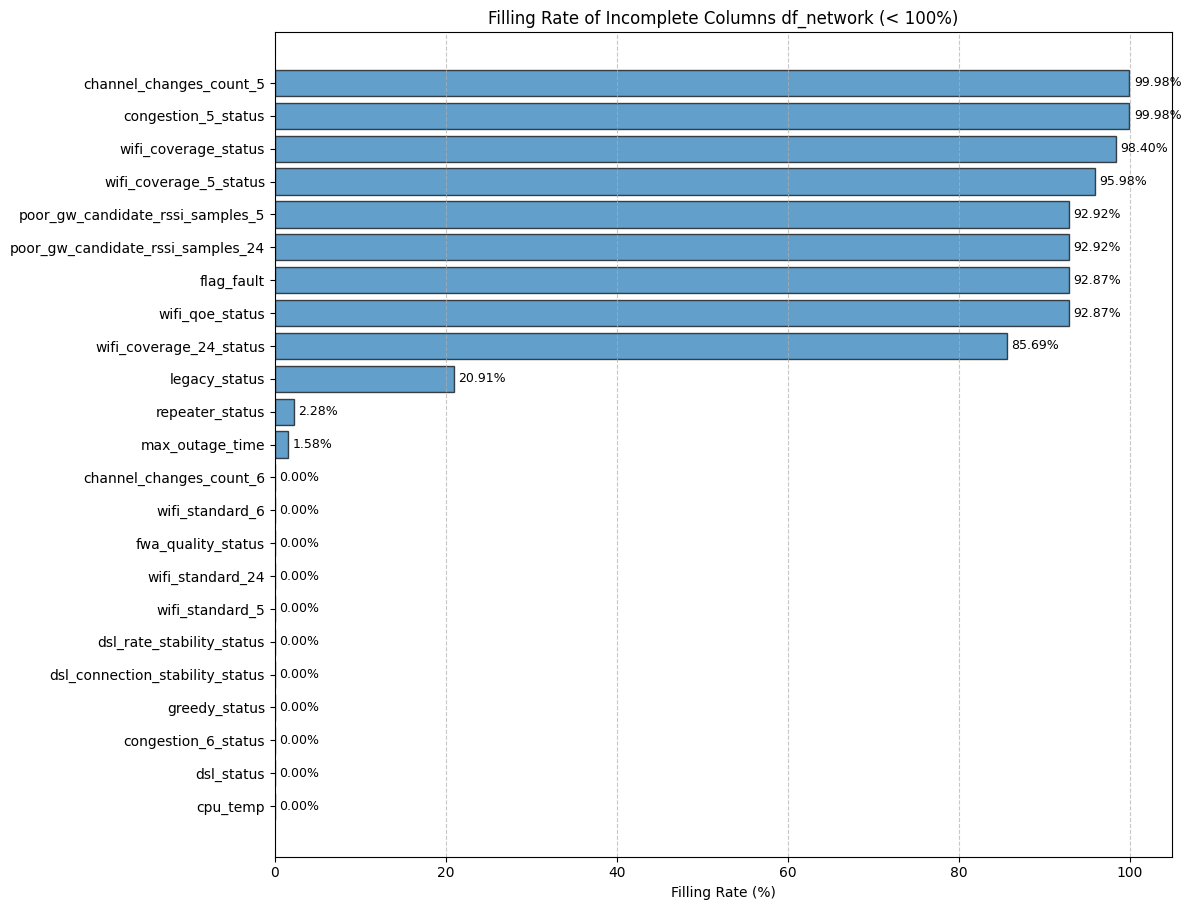

In [ ]:
# Plot incomplete columns
plt.figure(figsize=(12, 0.4 * len(incomplete_columns)))  # Dynamically scale height
bars = plt.barh(incomplete_columns.index, incomplete_columns.values, color=['#1f77b4'], alpha=0.7, edgecolor='black')

# Add value labels
for bar in bars:
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
             f"{bar.get_width():.2f}%", va='center', fontsize=9)

plt.xlabel("Filling Rate (%)")
plt.title("Filling Rate of Incomplete Columns df_network (< 100%)")
plt.xlim(0, 105)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


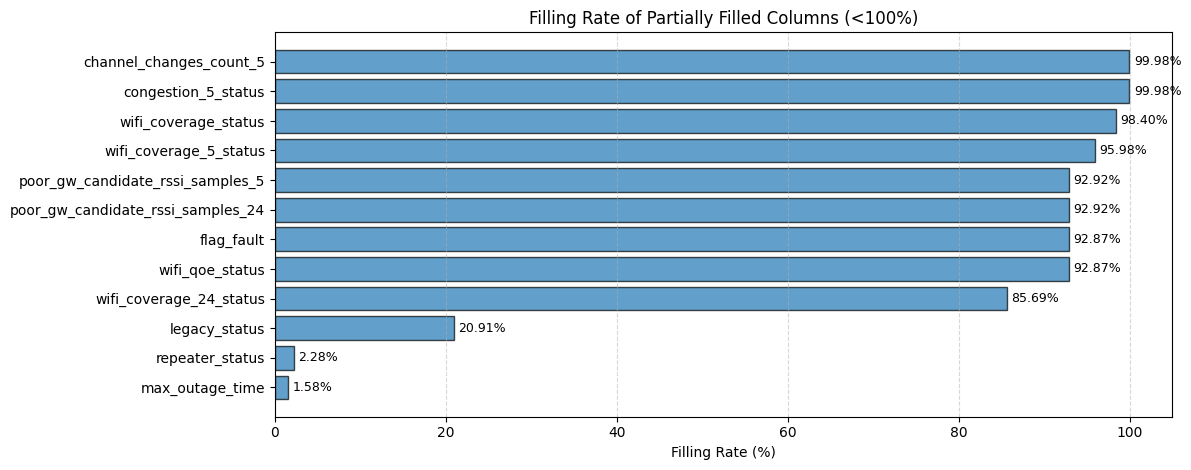

In [ ]:
# Filter to only columns with filling rate 1–99%
filtered = incomplete_columns[(incomplete_columns > 0) & (incomplete_columns < 100)]

plt.figure(figsize=(12, 0.4 * len(filtered)))  # Scale height to number of bars
bars = plt.barh(filtered.index, filtered.values, color=['#1f77b4'], alpha=0.7, edgecolor='black')

# Add value labels
for bar in bars:
    plt.text(
        bar.get_width() + 0.5,
        bar.get_y() + bar.get_height() / 2,
        f"{bar.get_width():.2f}%",
        va='center',
        fontsize=9
    )

plt.xlabel("Filling Rate (%)")
plt.title("Filling Rate of Partially Filled Columns (<100%)")
plt.xlim(0, 105)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Data Cleaning

## Drop rows with missing flag_fault

In [ ]:
# Drop rows with missing flag_fault
original_len = len(df_merged)

df_merged = df_merged.dropna(subset=['flag_fault']).reset_index(drop=True)

print(f"Removed {original_len - len(df_merged)} rows with missing flag_fault")

## Drop empty columns

In [ ]:
# Check which columns are completely empty (all values are NaN)
empty_columns = df_merged.columns[df_merged.isnull().all()].tolist()

# Print result
if empty_columns:
    print(f"Number of rows and columns: {df_merged.shape}")
    print(f"Number of empty columns: {len(empty_columns)}")
    print(f"Empty column names: {(empty_columns)}")
else:
    print("No empty columns")

In [ ]:
# Drop NaN columns
df_merged = df_merged.dropna(axis=1, how='all')
print(f"Number of rows and columns: {df_merged.shape}")

## Drop columns with filling rate less than 50%

In [ ]:
# Calculate percentage of non-null values for each column
filling_rates = 100 * df_merged.count() / df_merged.shape[0]

# Round to 2 decimal places
filling_rates = filling_rates.round(2)

# Identify columns with < 50% filled
low_fill_columns = filling_rates[filling_rates < 50].index.tolist()

# Drop those columns
df_merged = df_merged.drop(columns=low_fill_columns)

# Print summary
print(f"Dropped {len(low_fill_columns)}")
print(f"low-filling columns (<50% filled): {low_fill_columns}")
print(f"New shape: {df_merged.shape}")

In [ ]:
# List of columns to keep even if they have constant values
columns_to_keep = ['analysis_date']

# Identify constant columns excluding the ones to keep
constant_columns = [
    col for col in df_merged.columns
    if df_merged[col].nunique(dropna=False) == 1 and col not in columns_to_keep
]

# Drop those columns
df_merged = df_merged.drop(columns=constant_columns)

# Print summary
print(f"Dropped {len(constant_columns)}")
print(f"constant columns: {constant_columns}")

In [ ]:
df_merged.head()

## Drop features with possible data leakage

In [ ]:
# Drop leak features
leak_features = ['wifi_qoe_status', 'poor_qoe_samples']

# Drop those columns
df_merged = df_merged.drop(columns=leak_features)

# Print summary
print(f"Dropped {len(leak_features)}")
print(f"New shape: {df_merged.shape}")

## Drop irrelevant columns

In [ ]:
# Drop irrelavant columns and leak features
irrelevant_columns = ['script_boots', 'id', 'analysis_id']

# Drop those columns
df_merged = df_merged.drop(columns=irrelevant_columns)

# Print summary
print(f"Dropped {len(irrelevant_columns)}")
print(f"New shape: {df_merged.shape}")

In [ ]:
# Calculate percentage of non-null values for each column
filling_rates = 100 * df_merged.count() / df_merged.shape[0]

# Round to 4 decimal places
filling_rates = filling_rates.round(4)

# Filter and sort columns with less than 100% filled
incomplete_columns = filling_rates[filling_rates < 100].sort_values(ascending=False)

# Print the result
if not incomplete_columns.empty:
    print("Columns with less than 100% non-null values (ascending):")
    print(incomplete_columns)
    print(len(incomplete_columns))

    # Calculate and print the number of missing rows for each incomplete column
    print("\nNumber of missing rows per incomplete column:")
    missing_counts = df_merged[incomplete_columns.index].isnull().sum()
    print(missing_counts)
else:
    print("All columns are 100% complete.")

## Impute missing rows using backward fill

In [ ]:
# Sort analysis_date and device_id
df_merged = df_merged.sort_values(['device_id', 'analysis_date'])

# Define columns that need to be fill
columns_to_fill = incomplete_columns.index

# Backward Fill
for col in columns_to_fill:
    df_merged[col] = df_merged.groupby('device_id')[col].transform('bfill')

# Report how many values are still missing
missing_summary = df_merged[columns_to_fill].isnull().sum()
missing_summary = missing_summary[missing_summary > 0]

if missing_summary.empty:
    print("All missing values filled successfully.")
else:
    print("Remaining missing values after fill:")
    print(missing_summary)

## Drop missing rows

In [ ]:
# Count missing rows before dropping
missing_rows = df_merged.shape[0] - df_merged.dropna().shape[0]

# Drop missing rows
df_merged = df_merged.dropna()

# Print summary
print(f"Dropped {missing_rows} rows with missing values")
print(f"New shape: {df_merged.shape}")

## Sort time and change date format

In [ ]:
# Sort by time
df_merged = df_merged.sort_values('analysis_date')
print(df_merged['analysis_date'])

In [ ]:
# Change analysis_date to datetime format
df_merged["analysis_date"] = pd.to_datetime(df_merged["analysis_date"])
df_merged = df_merged.sort_values(["device_id", "analysis_date"])

# Feature Engineering - Predict Wifi Fault

## Ordinal Encoder

In [ ]:
# Ensure the column is string type
df_merged['congestion_5_status'] = df_merged['congestion_5_status'].astype(str)
df_merged['congestion_24_status'] = df_merged['congestion_24_status'].astype(str)
df_merged['band_usage_24_status'] = df_merged['band_usage_24_status'].astype(str)

# Define the order of categories
encoder = OrdinalEncoder(categories=[['POOR', 'MID', 'GOOD']])

# Apply ordinal encoding
df_merged['congestion_5_status'] = encoder.fit_transform(df_merged[['congestion_5_status']])
df_merged['congestion_24_status'] = encoder.fit_transform(df_merged[['congestion_24_status']])
df_merged['band_usage_24_status'] = encoder.fit_transform(df_merged[['band_usage_24_status']])

In [ ]:
df_merged[['congestion_5_status', 'congestion_24_status', 'band_usage_24_status']]

,congestion_5_status,congestion_24_status,band_usage_24_status
13330,2.0,0.0,1.0
32909,2.0,2.0,1.0
371206,2.0,1.0,1.0
43999,2.0,0.0,1.0
57439,2.0,0.0,1.0
...,...,...,...
467360,2.0,0.0,1.0
497230,2.0,0.0,1.0
507254,2.0,0.0,1.0
533480,2.0,0.0,1.0


In [ ]:
df_merged[['congestion_5_status', 'congestion_24_status', 'band_usage_24_status']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 499246 entries, 13330 to 555156
Data columns (total 3 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   congestion_5_status   499246 non-null  float64
 1   congestion_24_status  499246 non-null  float64
 2   band_usage_24_status  499246 non-null  float64
dtypes: float64(3)
memory usage: 15.2 MB


In [ ]:
# First, convert to numeric (handle errors like non-numeric strings)
cols_to_convert = ['congestion_5_status', 'congestion_24_status', 'band_usage_24_status']

# Convert to numeric with error coercion, then to Int64 (nullable integer)
for col in cols_to_convert:
    df_merged[col] = pd.to_numeric(df_merged[col], errors='coerce').astype('Int64')  # Use 'Int64' to handle NaN

In [ ]:
# Check type
df_merged[['congestion_5_status', 'congestion_24_status', 'band_usage_24_status']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 499246 entries, 13330 to 555156
Data columns (total 3 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   congestion_5_status   499246 non-null  Int64
 1   congestion_24_status  499246 non-null  Int64
 2   band_usage_24_status  499246 non-null  Int64
dtypes: Int64(3)
memory usage: 16.7 MB


In [ ]:
# Ensure the column is string type
df_merged['wifi_coverage_status'] = df_merged['wifi_coverage_status'].astype(str)
df_merged['wifi_coverage_24_status'] = df_merged['wifi_coverage_24_status'].astype(str)
df_merged['wifi_coverage_5_status'] = df_merged['wifi_coverage_5_status'].astype(str)

# Define the order of categories
encoder = OrdinalEncoder(categories=[['POOR', 'MID', 'HIGH']])

# Apply ordinal encoding
df_merged['wifi_coverage_status'] = encoder.fit_transform(df_merged[['wifi_coverage_status']])
df_merged['wifi_coverage_24_status'] = encoder.fit_transform(df_merged[['wifi_coverage_24_status']])
df_merged['wifi_coverage_5_status'] = encoder.fit_transform(df_merged[['wifi_coverage_5_status']])

In [ ]:
# Check data types for encoding columns
df_merged[['wifi_coverage_status', 'wifi_coverage_24_status', 'wifi_coverage_5_status']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 499246 entries, 13330 to 555156
Data columns (total 3 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   wifi_coverage_status     499246 non-null  float64
 1   wifi_coverage_24_status  499246 non-null  float64
 2   wifi_coverage_5_status   499246 non-null  float64
dtypes: float64(3)
memory usage: 15.2 MB


In [ ]:
df_merged[['wifi_coverage_status', 'wifi_coverage_24_status', 'wifi_coverage_5_status']]

,wifi_coverage_status,wifi_coverage_24_status,wifi_coverage_5_status
13330,0.0,0.0,1.0
32909,1.0,0.0,1.0
371206,0.0,0.0,1.0
43999,0.0,0.0,1.0
57439,1.0,0.0,1.0
...,...,...,...
467360,1.0,1.0,0.0
497230,0.0,1.0,0.0
507254,1.0,1.0,0.0
533480,1.0,1.0,0.0


In [ ]:
# Check shape
df_merged.shape

(499246, 58)

## TSFRESH

### Ensure all devices appear across 21 days

In [ ]:
# Ensure each device appears on all 21 days
expected_days = df_merged["analysis_date"].nunique()

# Count how many days each device_id appears
device_day_counts = df_merged.groupby("device_id")["analysis_date"].nunique()

# Keep only devices with full 21-day data
valid_devices = device_day_counts[device_day_counts == expected_days].index

# Filter df_tsfresh
df_merged = df_merged[df_merged["device_id"].isin(valid_devices)].copy()

# Print
print(f'df_merged shape {df_merged.shape}')

df_merged shape (347520, 58)


In [ ]:
# Prepare TSFRESH format
numeric_cols = df_merged.select_dtypes(include=[np.number]).columns.tolist()

# Print
print(f"Total {len(numeric_cols)} columns:")
print(numeric_cols)

Total 55 columns:
['reboots', 'ap_count', 'total_samples_24', 'total_samples_5', 'good_samples_24', 'good_samples_5', 'number_of_wifi_clients', 'cpu_load', 'free_memory', 'lifemote_cpu_load', 'congested_sample_5_count', 'congested_sample_active_5_count', 'congestion_5_status', 'sample_active_5_count', 'poor_gw_candidate_rssi_samples_24', 'poor_gw_candidate_rssi_samples_5', 'rssi_samples_24', 'rssi_samples_5', 'congested_sample_24_count', 'congested_sample_active_24_count', 'congestion_24_status', 'sample_active_24_count', 'poor_samples_24', 'poor_samples_5', 'good_active_samples_24', 'good_active_samples_5', 'mid_active_samples_24', 'mid_active_samples_5', 'mid_samples_24', 'mid_samples_5', 'poor_active_samples_24', 'poor_active_samples_5', 'total_active_samples_24', 'total_active_samples_5', 'uptime_in_minutes', 'wifi_coverage_24_status', 'wifi_coverage_5_status', 'wifi_coverage_status', 'outage_event_count', 'sum_outage_time', 'regular_update_drop_count', 'high_cpu_load_samples', 'lo

### Drop low variance columns

In [ ]:
# Step 5 (optional): Drop columns with low variance
low_variance_cols = df_merged[numeric_cols].std()[
    df_merged[numeric_cols].std() < 1e-3
].index.tolist()
numeric_cols = [col for col in numeric_cols if col not in low_variance_cols]

# Print
print(f"Selected {len(numeric_cols)} useful columns:")
print(numeric_cols)

Selected 55 useful columns:
['reboots', 'ap_count', 'total_samples_24', 'total_samples_5', 'good_samples_24', 'good_samples_5', 'number_of_wifi_clients', 'cpu_load', 'free_memory', 'lifemote_cpu_load', 'congested_sample_5_count', 'congested_sample_active_5_count', 'congestion_5_status', 'sample_active_5_count', 'poor_gw_candidate_rssi_samples_24', 'poor_gw_candidate_rssi_samples_5', 'rssi_samples_24', 'rssi_samples_5', 'congested_sample_24_count', 'congested_sample_active_24_count', 'congestion_24_status', 'sample_active_24_count', 'poor_samples_24', 'poor_samples_5', 'good_active_samples_24', 'good_active_samples_5', 'mid_active_samples_24', 'mid_active_samples_5', 'mid_samples_24', 'mid_samples_5', 'poor_active_samples_24', 'poor_active_samples_5', 'total_active_samples_24', 'total_active_samples_5', 'uptime_in_minutes', 'wifi_coverage_24_status', 'wifi_coverage_5_status', 'wifi_coverage_status', 'outage_event_count', 'sum_outage_time', 'regular_update_drop_count', 'high_cpu_load_sam

### Drop columns with high VIF

In [ ]:
# Select only numeric columns and drop rows with NaNs
numeric_df = df_merged.select_dtypes(include=[np.number]).dropna()

# Sample dataset
if len(numeric_df) > 1_000_000:
    numeric_df = numeric_df.sample(n=1_000_000, random_state=42)

# Drop the target variable
features_df = numeric_df.drop(columns=['flag_fault'], errors='ignore')  # ignore in case it doesn't exist

# Add constant term
features_with_const = add_constant(features_df)

# Ensure all values are float64 (required by statsmodels)
features_with_const = features_with_const.astype(np.float64)

# Compute VIF
vif_data = pd.DataFrame({
    "feature": features_with_const.columns,
    "VIF": [
        variance_inflation_factor(features_with_const.values, i)
        for i in range(features_with_const.shape[1])
    ]
})

vif_data.sort_values(by="VIF", ascending=False)

del numeric_df

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [ ]:
# Filter VIF > 10
high_vif_features = vif_data[vif_data["VIF"] > 10]

# Convert to list and remove 'const'
high_vif_features_list = high_vif_features["feature"].tolist()
high_vif_features_list = [col for col in high_vif_features_list if col != 'const']

# Drop from original DataFrame
df_merged = df_merged.drop(columns=high_vif_features_list)

print("Features with VIF > 10:", high_vif_features_list)
print(f"New shape: {df_merged.shape}")

Features with VIF > 10: ['total_samples_24', 'total_samples_5', 'good_samples_5', 'rssi_samples_24', 'rssi_samples_5', 'sample_active_24_count', 'good_active_samples_24', 'good_active_samples_5', 'mid_active_samples_24', 'mid_active_samples_5', 'poor_active_samples_24', 'poor_active_samples_5', 'total_active_samples_24', 'total_active_samples_5', 'poor_active_iot_weighted_samples_24']
New shape: (347520, 43)


In [ ]:
df_merged['analysis_date'].nunique()

30

### Create rolling windows



In [ ]:
# Create rolling windows
def create_rolling_windows(df, feature_days=14, label_days=5, verbose=True):
    """
    Generate rolling windows with feature and label periods per device.

    Parameters:
    - df: DataFrame with columns ['device_id', 'analysis_date', ...]
    - feature_days: number of days for feature window
    - label_days: number of days for label window

    Returns:
    - rolling_windows: list of (feature_df, rolling_id, label_date, flag_label)
    """
    df = df.sort_values(['device_id', 'analysis_date']).copy()
    df["analysis_date"] = pd.to_datetime(df["analysis_date"])
    rolling_windows = []

    for device_id, device_df in df.groupby("device_id"):
        device_df = device_df.reset_index(drop=True)
        all_dates = device_df["analysis_date"].tolist()

        for i in range(len(all_dates) - feature_days - label_days + 1):
            feature_start = all_dates[i]
            feature_end = all_dates[i + feature_days - 1]
            label_start = all_dates[i + feature_days]
            label_end = all_dates[i + feature_days + label_days - 1]

            feature_df = device_df[
                (device_df["analysis_date"] >= feature_start) &
                (device_df["analysis_date"] <= feature_end)
            ].copy()

            label_df = device_df[
                (device_df["analysis_date"] >= label_start) &
                (device_df["analysis_date"] <= label_end)
            ]

            if feature_df.empty or label_df.empty:
                continue

            # Label = 1 if any fault occurs in label window
            flag_label = int(label_df["flag_fault"].max())

            # Unique rolling ID = device + label date (acts as 'chunk_id' for TSFRESH)
            rolling_id = f"{device_id}__{label_start.strftime('%Y%m%d')}"

            feature_df["rolling_id"] = rolling_id
            rolling_windows.append((feature_df, rolling_id, label_start, flag_label))

    if verbose:
        print(f"Total rolling windows created: {len(rolling_windows)}")
        label_dist = pd.Series([label for _, _, _, label in rolling_windows]).value_counts().to_dict()
        print(f"Label distribution: {label_dist}")

    return rolling_windows


In [ ]:
rolling_windows = create_rolling_windows(df_merged)

Total rolling windows created: 139008
Label distribution: {0: 90312, 1: 48696}


In [ ]:
# Flatten to TSFRESH input
df_tsfresh = pd.concat([fw for fw, _, _, _ in rolling_windows])
df_tsfresh["device_id"] = [rid for _, rid, _, _ in rolling_windows for _ in range(14)]  # 14 days per window
df_tsfresh.drop(columns=["rolling_id"], errors="ignore", inplace=True)

# Label vector
labels = {rid: label for _, rid, _, label in rolling_windows}
y = pd.Series(labels)

### Check top 15 correlated features

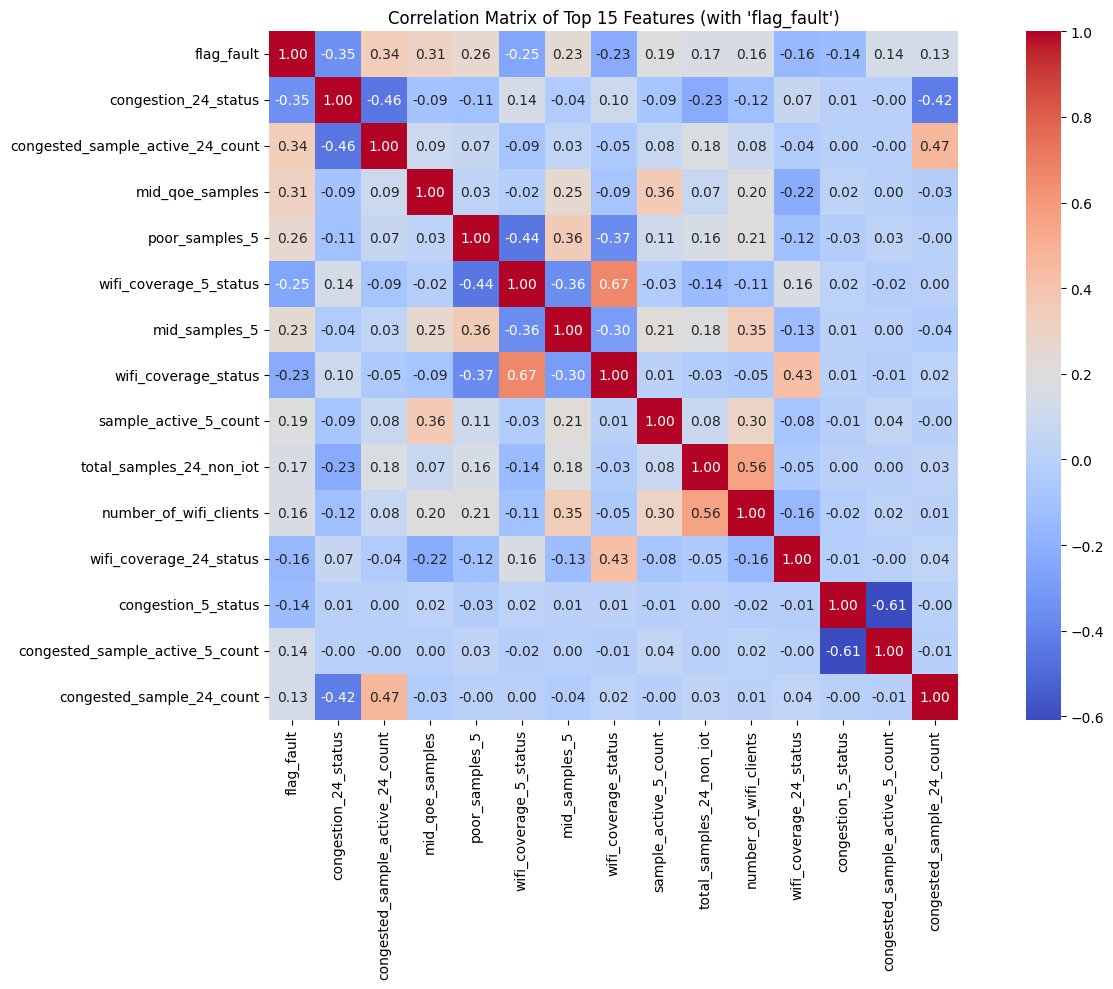

In [ ]:
# Get only numeric columns
numeric_cols = df_merged.select_dtypes(include=["number"]).columns


# Drop columns with NaN
df_numeric = df_merged[numeric_cols].dropna(axis=1).copy()

# Get top 10 features most correlated (absolute) with flag_fault
top_15_corr_cols = (
    df_numeric.corrwith(df_merged["flag_fault"])
    .abs()
    .sort_values(ascending=False)
    .head(15)
    .index
)

# Add 'flag_fault' to the selected columns
selected_cols = top_15_corr_cols.tolist()

# Plot correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(df_merged[selected_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Matrix of Top 15 Features (with 'flag_fault')")
plt.tight_layout()
plt.show()


### Extract TSFRESH features

In [ ]:
# Automatically select all valid numeric time-series columns (excluding ID/timestamp/target)
exclude_cols = ['device_id', 'analysis_date', 'flag_fault', 'flag_call']  # exclude any target, ID, date
tsfresh_feature_cols = df_merged.select_dtypes(include=["number"]).columns.difference(exclude_cols).tolist()

print("Columns selected for TSFRESH:", tsfresh_feature_cols)


Columns selected for TSFRESH: ['ap_count', 'band_usage_24_status', 'channel_changes_count_24', 'channel_changes_count_5', 'chunk_number', 'congested_sample_24_count', 'congested_sample_5_count', 'congested_sample_active_24_count', 'congested_sample_active_5_count', 'congestion_24_status', 'congestion_5_status', 'cpu_load', 'firmware_upgrades', 'free_memory', 'good_samples_24', 'high_cpu_load_samples', 'high_mem_usage_samples', 'lifemote_cpu_load', 'low_free_memory_samples', 'mem_usage', 'mid_qoe_samples', 'mid_samples_24', 'mid_samples_5', 'number_of_wifi_clients', 'outage_event_count', 'poor_gw_candidate_rssi_samples_24', 'poor_gw_candidate_rssi_samples_5', 'poor_iot_weighted_samples_24', 'poor_samples_24', 'poor_samples_5', 'reboots', 'regular_update_drop_count', 'sample_active_5_count', 'sum_outage_time', 'total_samples_24_non_iot', 'uptime_in_minutes', 'wifi_coverage_24_status', 'wifi_coverage_5_status', 'wifi_coverage_status']


In [ ]:
# Create label Series - optimized to avoid intermediate dict
y = pd.Series(
    data=[label for _, _, _, label in rolling_windows],
    index=[rid for _, rid, _, _ in rolling_windows]
)

# Process rolling windows in chunks to reduce memory peaks
chunk_size = 1000  # Adjust based on your memory constraints
tsfresh_chunks = []

for i in range(0, len(rolling_windows), chunk_size):
    chunk = rolling_windows[i:i+chunk_size]

    # Process chunk
    chunk_data = []
    device_ids = []
    for fw, rid, _, _ in chunk:
        chunk_data.append(fw)
        device_ids.extend([rid] * len(fw))

    chunk_df = pd.concat(chunk_data)
    chunk_df["device_id"] = device_ids

    # Convert numeric columns in place
    for col in tsfresh_feature_cols:
        chunk_df[col] = pd.to_numeric(chunk_df[col], errors="coerce", downcast="float")

    tsfresh_chunks.append(chunk_df)

# Concatenate all chunks
df_tsfresh = pd.concat(tsfresh_chunks, copy=False)

# Extract TSFRESH features in chunks
X_chunks = []
for device_id_chunk in np.array_split(df_tsfresh["device_id"].unique(), 4):
    chunk_mask = df_tsfresh["device_id"].isin(device_id_chunk)
    X_chunk = extract_features(
        df_tsfresh.loc[chunk_mask, ["device_id", "analysis_date"] + tsfresh_feature_cols],
        column_id="device_id",
        column_sort="analysis_date",
        default_fc_parameters=MinimalFCParameters(),
        n_jobs=1
    )
    impute(X_chunk)
    X_chunks.append(X_chunk)

X = pd.concat(X_chunks, copy=False)

# Align features and labels - using index intersection directly
common_index = X.index.intersection(y.index)
X_final = X.loc[common_index]
y_final = y.loc[common_index]

# Print
print(f"Final shape: {X_final.shape}")
print("Label distribution:", y_final.value_counts().to_dict())

Feature Extraction: 100%|██████████| 1355328/1355328 [08:05<00:00, 2792.10it/s]


Final shape: (139008, 390)
Label distribution: {0: 90312, 1: 48696}


### Feature Selection

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import average_precision_score
from xgboost import XGBClassifier

# First create and fit your XGBoost model
xgb_selector = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    eval_metric='aucpr',
    random_state=42,
    scale_pos_weight=(y_final == 0).sum() / (y_final == 1).sum()
)
xgb_selector.fit(X_final, y_final)

# Now you can use it for feature selection
thresholds = np.linspace(0, max(xgb_selector.feature_importances_), 20)
results = []

for thresh in thresholds:
    selector = SelectFromModel(xgb_selector, threshold=thresh, prefit=True)
    X_sel_array = selector.transform(X_final)

    if X_sel_array.shape[1] == 0:
        continue

    X_sel = pd.DataFrame(
        X_sel_array,
        columns=X_final.columns[selector.get_support()],
        index=X_final.index
    )

    model = XGBClassifier(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        eval_metric='aucpr',
        random_state=42,
        scale_pos_weight=(y_final == 0).sum() / (y_final == 1).sum()
    )
    model.fit(X_sel, y_final)

    y_pred = model.predict_proba(X_sel)[:, 1]
    pr_auc = average_precision_score(y_final, y_pred)
    results.append((thresh, X_sel.shape[1], pr_auc))

# Show results
df_results = pd.DataFrame(results, columns=["threshold", "n_features", "pr_auc"])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, bu

In [ ]:
df_results

,threshold,n_features,pr_auc
0,0.000000,390,0.791657
1,0.007156,25,0.780199
2,0.014311,15,0.772791
3,0.021467,8,0.759376
4,0.028623,6,0.748989
5,0.035779,6,0.748989
6,0.042934,6,0.748989
7,0.050090,4,0.746564
8,0.057246,4,0.746564
9,0.064402,3,0.703651


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:46:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/tmp/ipython-input-60-2249858696.py:37: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_relevant, plot_type="bar", max_display=15)  # Changed to X_relevant


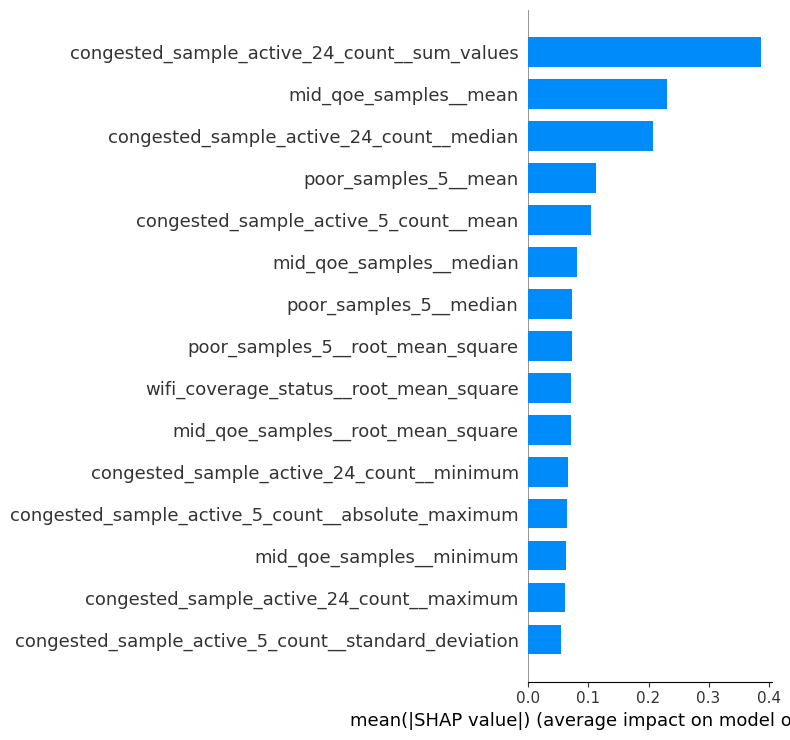

<Figure size 640x480 with 0 Axes>

In [ ]:
from tsfresh.feature_selection.relevance import calculate_relevance_table
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from tsfresh.feature_extraction import MinimalFCParameters
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

# === Step 6: Drop low-variance or NaN-heavy features ===
X_clean = X_final.dropna(axis=1, thresh=int(0.8 * len(X_final)))  # keep if <20% NaN
X_clean = X_clean.loc[:, X_clean.std() > 1e-5]                    # drop near-constant

# === Step 7: Univariate relevance filtering (optional) ===
relevance_table = calculate_relevance_table(X_clean, y_final)
relevant_features = relevance_table[relevance_table.relevant == True]["feature"]
X_relevant = X_clean[relevant_features]

# Refit a new model just for SHAP
xgb_final = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=(y_final == 0).sum() / (y_final == 1).sum()
)
xgb_final.fit(X_relevant, y_final)  # Changed from X_final_selected to X_relevant

# Use TreeExplainer safely
explainer = shap.TreeExplainer(xgb_final)
shap_values = explainer.shap_values(X_relevant)  # Changed to X_relevant

# Plot
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, X_relevant, plot_type="bar", max_display=15)  # Changed to X_relevant

# Save the plot with bounding box to avoid clipping
plt.tight_layout()
plt.savefig("shap_summary_clean.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
from sklearn.feature_selection import SelectFromModel
import pandas as pd
import numpy as np

# 1. FIRST FIT THE MODEL ON YOUR CURRENT DATA
if not hasattr(xgb_selector, 'feature_importances_') or \
   len(xgb_selector.feature_importances_) != X_relevant.shape[1]:
    print("Re-fitting xgb_selector to match current feature dimensions...")
    xgb_selector.fit(X_relevant, y_final)

# 2. VERIFY DIMENSIONS MATCH
print(f"Model features: {len(xgb_selector.feature_importances_)}")
print(f"X_relevant features: {X_relevant.shape[1]}")

# 3. CREATE SELECTOR WITH PROPER FEATURE ALIGNMENT
optimal_threshold = 0.007156
selector = SelectFromModel(xgb_selector, threshold=optimal_threshold, prefit=True)

# 4. TRANSFORM WITH ERROR HANDLING
try:
    X_selected_array = selector.transform(X_relevant)
except Exception as e:
    print("\nCRITICAL ERROR - Feature mismatch details:")
    print(f"Model expected {len(xgb_selector.feature_importances_)} features")
    print(f"X_relevant has {X_relevant.shape[1]} features")

    # Check if feature names exist and match
    if hasattr(X_relevant, 'columns'):
        print("\nFirst 5 feature names in X_relevant:", X_relevant.columns[:5])
    if hasattr(xgb_selector, 'feature_names_in_'):
        print("First 5 features model was trained on:", xgb_selector.feature_names_in_[:5])

    raise ValueError("Feature dimensions/names don't match. Please ensure: \n"
                   "1. xgb_selector is fitted on the exact same features as X_relevant\n"
                   "2. The feature order is identical") from e

# 5. PROCEED WITH SELECTION
selected_columns = X_relevant.columns[selector.get_support()]
X_final = pd.DataFrame(X_selected_array,
                     columns=selected_columns,
                     index=X_relevant.index)

# 6. FINAL CHECKS
print("\nSUCCESSFUL TRANSFORMATION:")
print(f"Original features: {X_relevant.shape[1]}")
print(f"Selected features: {X_final.shape[1]}")
print("Selected columns:", selected_columns.tolist())

Re-fitting xgb_selector to match current feature dimensions...
Model features: 317
X_relevant features: 317

SUCCESSFUL TRANSFORMATION:
Original features: 317
Selected features: 45
Selected columns: ['wifi_coverage_5_status__mean', 'wifi_coverage_5_status__root_mean_square', 'congested_sample_24_count__mean', 'congested_sample_active_24_count__sum_values', 'sample_active_5_count__mean', 'congested_sample_5_count__variance', 'congested_sample_active_5_count__absolute_maximum', 'congested_sample_5_count__sum_values', 'poor_samples_5__mean', 'poor_samples_5__median', 'sample_active_5_count__median', 'congested_sample_active_5_count__standard_deviation', 'congested_sample_active_5_count__root_mean_square', 'congested_sample_active_5_count__variance', 'congested_sample_active_5_count__median', 'congested_sample_active_5_count__mean', 'congested_sample_active_24_count__root_mean_square', 'congested_sample_active_24_count__maximum', 'congested_sample_active_24_count__minimum', 'poor_samples_5

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


# Modeling

## Data Splitting

In [ ]:
# First split into train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_final, y_final,
    test_size=0.3,
    stratify=y_final,
    random_state=42
)

# Split temp into validation (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

# Print shape and distribution
print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

print("\nLabel distribution:")
print("Train:", y_train.value_counts(normalize=True).to_dict())
print("Val:  ", y_val.value_counts(normalize=True).to_dict())
print("Test: ", y_test.value_counts(normalize=True).to_dict())


Train shape: (97305, 45)
Validation shape: (20851, 45)
Test shape: (20852, 45)

Label distribution:
Train: {0: 0.6496891218334104, 1: 0.35031087816658957}
Val:   {0: 0.6497050501175003, 1: 0.35029494988249965}
Test:  {0: 0.6496738921925954, 1: 0.3503261078074046}


## Randomforest (RF)

In [ ]:
# Compute manual weight
class_counts = Counter(y_train)
total = sum(class_counts.values())

# Inverse frequency or balanced scaling
weight_0 = total / (2 * class_counts[0])
weight_1 = total / (2 * class_counts[1])

# Create dictionary
manual_weights = {0: weight_0, 1: weight_1}


In [ ]:
# Initialize the model parameters
rf_model = ExtraTreesClassifier(
    n_estimators=200,
    max_depth=3,
    min_samples_split=100,
    min_samples_leaf=50,
    max_features=0.1,
    max_samples=0.6,
    class_weight=manual_weights,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

# Train the model
rf_model.fit(X_train, y_train)

# Predict probabilities
y_val_proba = rf_model.predict_proba(X_val)[:, 1]
y_test_proba = rf_model.predict_proba(X_test)[:, 1]


# Threshold Optimization (Direct Implementation)
# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)

# Calculate F1 scores
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)

# Find optimal threshold (max F1)
optimal_idx = np.argmax(f1_scores[:-1])  # Exclude last value (edge case)
optimal_threshold = thresholds[optimal_idx]

# Evaluation with Optimal Threshold
# Convert to predicted labels using optimal threshold
y_val_pred_optimal = (y_val_proba >= optimal_threshold).astype(int)
y_test_pred_optimal = (y_test_proba >= optimal_threshold).astype(int)

# Also keep original 0.5 threshold for comparison
y_val_pred_default = (y_val_proba >= 0.5).astype(int)
y_test_pred_default = (y_test_proba >= 0.5).astype(int)

# Evaluation function (modified to show both thresholds)
def evaluate(y_true, y_pred, y_proba, dataset='Validation'):
    print(f"\n{dataset} Performance:")
    print(f"Threshold used    : {optimal_threshold if 'optimal' in dataset.lower() else 0.5}")
    print(f"ROC AUC           : {roc_auc_score(y_true, y_proba):.4f}")
    print(f"PR AUC            : {average_precision_score(y_true, y_proba):.4f}")
    print(f"Accuracy          : {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision         : {precision_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"Recall            : {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score          : {f1_score(y_true, y_pred):.4f}")
    # print(f"True Positives    : {sum((y_pred == 1) & (y_true == 1))}")
    # print(f"False Positives   : {sum((y_pred == 1) & (y_true == 0))}")

# Evaluate both thresholds
evaluate(y_val, y_val_pred_optimal, y_val_proba, "Validation (Optimal Threshold)")

evaluate(y_test, y_test_pred_optimal, y_test_proba, "Test (Optimal Threshold)")


Validation (Optimal Threshold) Performance:
Threshold used    : 0.48988285289002753
ROC AUC           : 0.8051
PR AUC            : 0.7197
Accuracy          : 0.7378
Precision         : 0.6071
Recall            : 0.7129
F1-Score          : 0.6558

Test (Optimal Threshold) Performance:
Threshold used    : 0.48988285289002753
ROC AUC           : 0.8054
PR AUC            : 0.7186
Accuracy          : 0.7406
Precision         : 0.6109
Recall            : 0.7143
F1-Score          : 0.6586


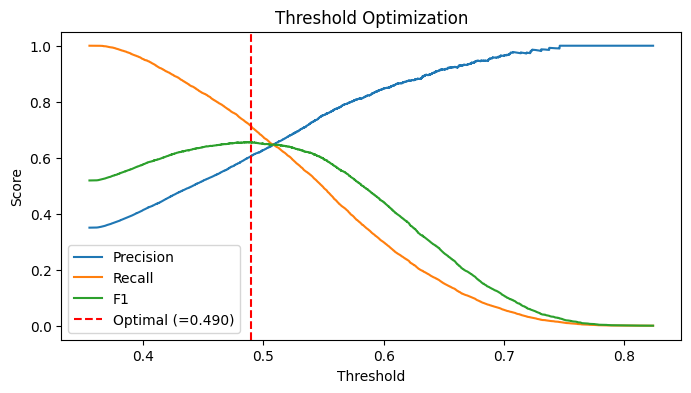


Optimal Threshold: 0.4899


In [ ]:
# Plot threshold analysis
plt.figure(figsize=(8, 4))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1')
plt.axvline(optimal_threshold, color='red', linestyle='--',
            label=f'Optimal (={optimal_threshold:.3f})')
plt.title('Threshold Optimization')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

print(f"\nOptimal Threshold: {optimal_threshold:.4f}")

### RF Plots & Optuna tuning

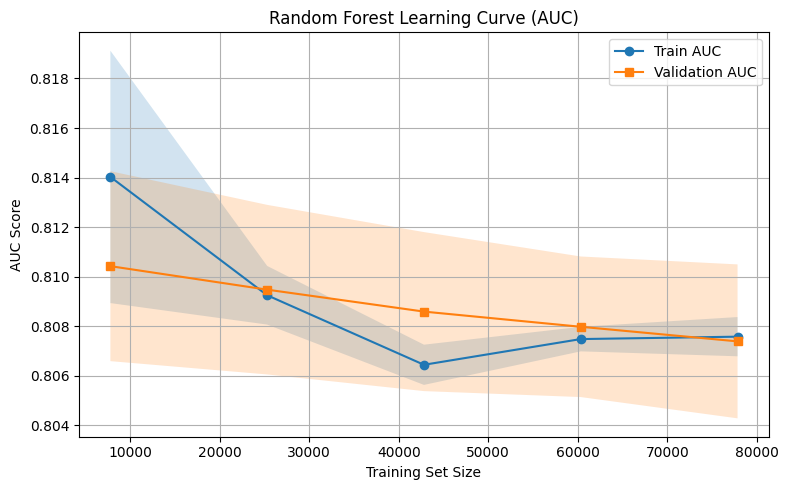

In [ ]:
# Define the metric and CV strategy
train_sizes, train_scores, val_scores = learning_curve(
    rf_model,
    X_train,
    y_train,
    cv=5,                        # 5-fold cross-validation
    scoring='roc_auc',           # AUC metric
    n_jobs=-1,                   # parallelize
    train_sizes=np.linspace(0.1, 1.0, 5),  # 5 points from 10% to 100%
    shuffle=True,
    random_state=42
)

# Calculate mean and std for plotting
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

# Plot learning curve
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, 'o-', label='Train AUC')
plt.plot(train_sizes, val_mean, 's-', label='Validation AUC')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)
plt.xlabel('Training Set Size')
plt.ylabel('AUC Score')
plt.title('Random Forest Learning Curve (AUC)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

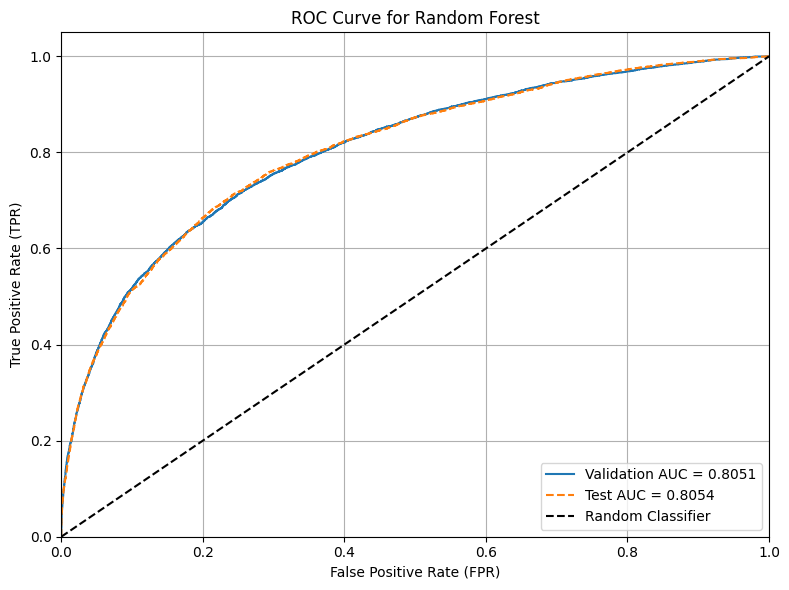

In [ ]:
# Plot ROC-AUC curve to check for overfitting
def plot_roc_curve(y_val, y_val_proba, y_test, y_test_proba):
    # Compute ROC curve and AUC for validation set
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)
    auc_val = auc(fpr_val, tpr_val)

    # Compute ROC curve and AUC for test set
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
    auc_test = auc(fpr_test, tpr_test)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_val, tpr_val, label=f'Validation AUC = {auc_val:.4f}')
    plt.plot(fpr_test, tpr_test, linestyle='--', label=f'Test AUC = {auc_test:.4f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve for Random Forest')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function using your probabilities
plot_roc_curve(y_val, y_val_proba, y_test, y_test_proba)


In [ ]:

# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.model_selection import RandomizedSearchCV

# # Define parameter grid
# param_grid = {
#     "n_estimators": [100, 200, 300],
#     "max_depth": [3, 5, 7, None],
#     "min_samples_split": [10, 30, 50, 70],
#     "min_samples_leaf": [10, 20, 30, 40],
#     "max_features": [0.1, 0.2, 0.3, 'sqrt'],
#     "max_samples": [0.6, 0.7, 0.8],
#     "bootstrap": [True, False]
# }

# # Initialize the model
# rf_model = ExtraTreesClassifier(
#     class_weight='balanced',
#     random_state=42,
#     n_jobs=-1
# )

# # Run randomized search
# search = RandomizedSearchCV(
#     estimator=rf_model,
#     param_distributions=param_grid,
#     n_iter=30,
#     scoring='roc_auc',
#     cv=3,
#     verbose=1,
#     n_jobs=-1,
#     random_state=42
# )

# # Fit on your training data
# search.fit(X_train, y_train)

# # Retrieve best model
# best_model = search.best_estimator_
# print("Best AUC:", search.best_score_)
# print("Best parameters:", search.best_params_)


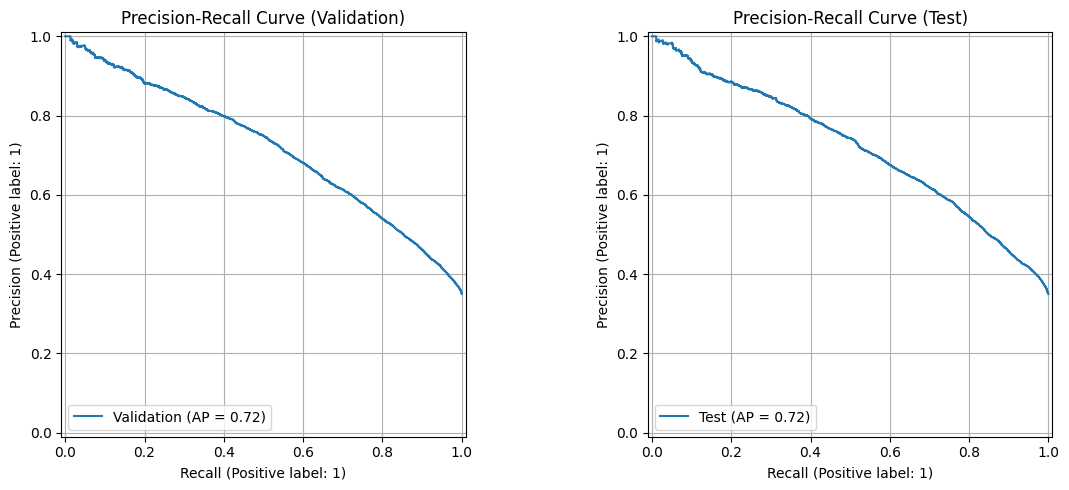

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt

# Create subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot validation curve
PrecisionRecallDisplay.from_predictions(
    y_val, y_val_proba, ax=axes[0], name="Validation"
)
axes[0].set_title("Precision-Recall Curve (Validation)")
axes[0].grid(True)

# Plot test curve
PrecisionRecallDisplay.from_predictions(
    y_test, y_test_proba, ax=axes[1], name="Test"
)
axes[1].set_title("Precision-Recall Curve (Test)")
axes[1].grid(True)

plt.tight_layout()
plt.show()

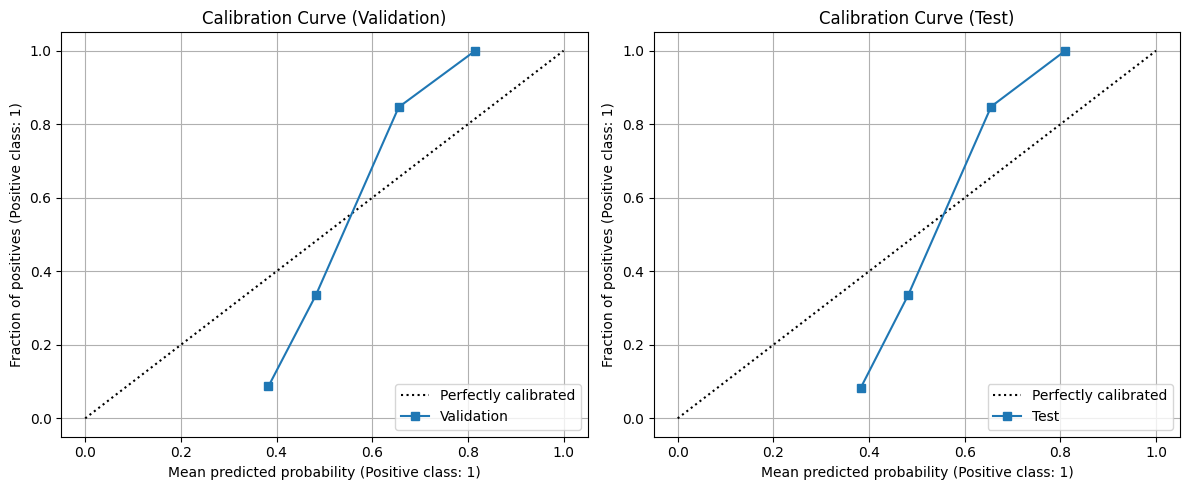

In [ ]:
from sklearn.calibration import CalibrationDisplay
import matplotlib.pyplot as plt

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot calibration for validation set
CalibrationDisplay.from_predictions(
    y_val, y_val_proba, ax=axes[0], name="Validation"
)
axes[0].set_title("Calibration Curve (Validation)")
axes[0].grid(True)

# Plot calibration for test set
CalibrationDisplay.from_predictions(
    y_test, y_test_proba, ax=axes[1], name="Test"
)
axes[1].set_title("Calibration Curve (Test)")
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# # Optuna hyperparameter tuning RandomForest
# def objective(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 500),
#         'max_depth': trial.suggest_int('max_depth', 5, 20),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
#         'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
#         'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
#     }

#     model = RandomForestClassifier(**params, random_state=42, n_jobs=-1)

#     # Use ROC AUC as scoring metric
#     score = cross_val_score(
#         model,
#         X_train,  # SMOTE-balanced tr
#         y_train,
#         scoring=make_scorer(roc_auc_score),
#         cv=3,  # 3-fold CV
#         n_jobs=-1
#     )
#     return score.mean()

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=10)  # Try 30 parameter combinations

# print("Best Parameters:")
# print(study.best_trial.params)

# print(f"Best AUC Score: {study.best_trial.value:.4f}")

## XGBoost

In [ ]:
# Compute class weight
# Count class distribution
class_counts = Counter(y_train)

num_negative = class_counts[0]
num_positive = class_counts[1]

scale_pos_weight = num_negative / num_positive

print(f"Class 0 (non-fault): {num_negative}")
print(f"Class 1 (fault): {num_positive}")
print(f"Scale_pos_weight: {scale_pos_weight:.2f}")

Class 0 (non-fault): 63218
Class 1 (fault): 34087
Scale_pos_weight: 1.85


In [ ]:
# Train XGBoost model
xgb_model = XGBClassifier(
    n_estimators=400,
    learning_rate=0.02,
    max_depth=3,
    min_child_weight=100,
    gamma=2,
    subsample=0.5,
    colsample_bytree=0.5,
    reg_alpha=5,
    reg_lambda=10,
    scale_pos_weight=scale_pos_weight,
    eval_metric=['auc', 'aucpr'],
    early_stopping_rounds=20,
    n_jobs=-1,
    random_state=42,
    tree_method='hist',
    max_bin=128
)

xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# Predict probabilities
y_val_proba = xgb_model.predict_proba(X_val)[:, 1]
y_test_proba = xgb_model.predict_proba(X_test)[:, 1]

# Automatically find best threshold (F1-score on validation)
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = [f1_score(y_val, (y_val_proba >= t).astype(int), zero_division=0) for t in thresholds]
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\n Best threshold from validation set: {best_threshold:.2f} (F1 = {best_f1:.4f})")

# Predict using optimal threshold
y_val_pred = (y_val_proba >= best_threshold).astype(int)
y_test_pred = (y_test_proba >= best_threshold).astype(int)

# Evaluation function
def evaluate(y_true, y_pred, y_proba, dataset, threshold):
    print(f"\n {dataset} Performance (Threshold = {threshold:.2f}):")
    print(f"ROC AUC  : {roc_auc_score(y_true, y_proba):.4f}")
    print(f"PR AUC   : {average_precision_score(y_true, y_proba):.4f}")
    print(f"Accuracy : {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"Recall   : {recall_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"F1-Score : {f1_score(y_true, y_pred, zero_division=0):.4f}")

# STEP 6: Evaluate both sets
evaluate(y_val, y_val_pred, y_val_proba, "Validation", best_threshold)
evaluate(y_test, y_test_pred, y_test_proba, "Test", best_threshold)



 Best threshold from validation set: 0.49 (F1 = 0.7031)

 Validation Performance (Threshold = 0.49):
ROC AUC  : 0.8491
PR AUC   : 0.7740
Accuracy : 0.7734
Precision: 0.6498
Recall   : 0.7659
F1-Score : 0.7031

 Test Performance (Threshold = 0.49):
ROC AUC  : 0.8487
PR AUC   : 0.7742
Accuracy : 0.7693
Precision: 0.6445
Recall   : 0.7617
F1-Score : 0.6982


### XGBoost Plots & Optuna tuning

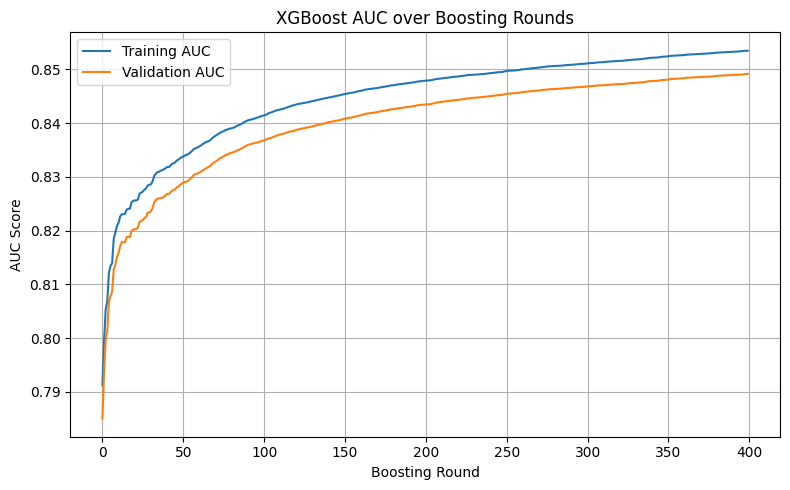

In [ ]:
# Define evaluation set
eval_set = [(X_train, y_train), (X_val, y_val)]

# Train and capture evaluation metrics
xgb_model.fit(
    X_train, y_train,
    eval_set=eval_set,
    verbose=False
)

# Extract AUC values over boosting rounds
results = xgb_model.evals_result()
train_auc = results['validation_0']['auc']
val_auc = results['validation_1']['auc']

# Plot the AUC curves
plt.figure(figsize=(8, 5))
plt.plot(train_auc, label='Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.xlabel("Boosting Round")
plt.ylabel("AUC Score")
plt.title("XGBoost AUC over Boosting Rounds")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


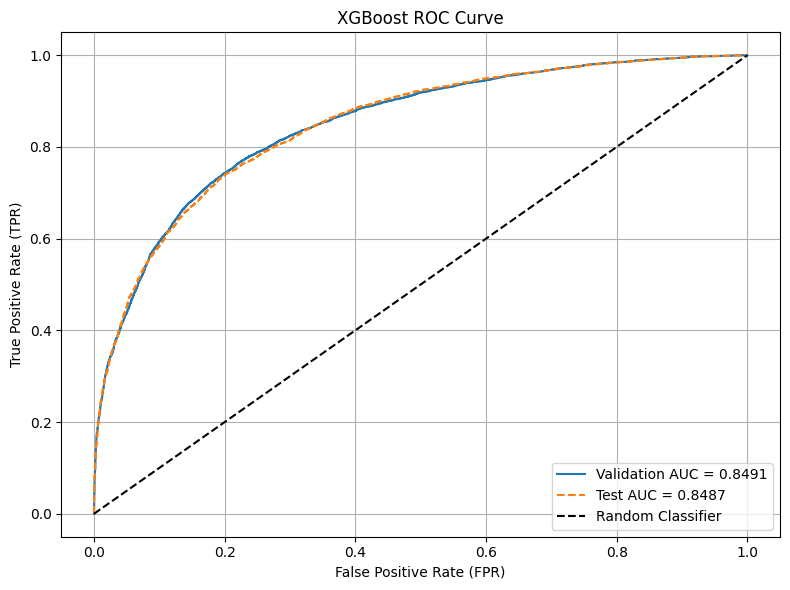

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curves and AUC
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)
auc_val = auc(fpr_val, tpr_val)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
auc_test = auc(fpr_test, tpr_test)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_val, tpr_val, label=f"Validation AUC = {auc_val:.4f}")
plt.plot(fpr_test, tpr_test, label=f"Test AUC = {auc_test:.4f}", linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("XGBoost ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

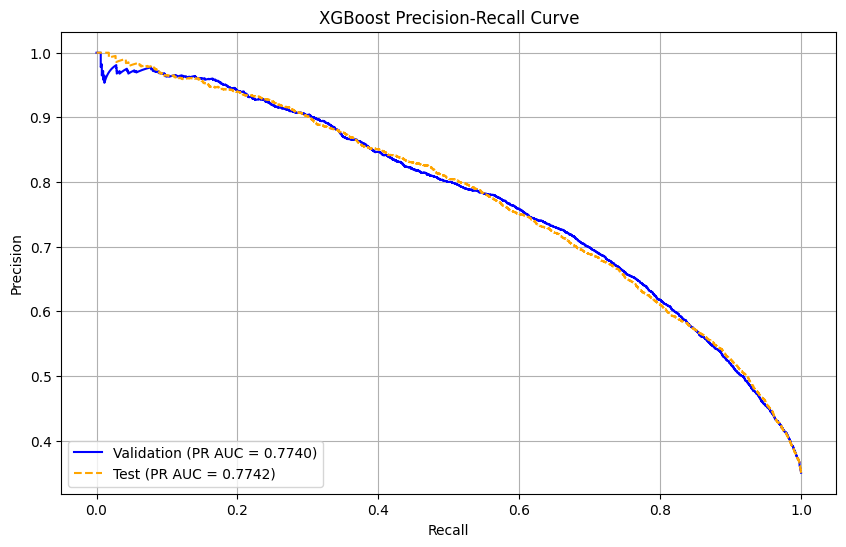

In [ ]:
# Predict Probabilitie
y_val_proba = xgb_model.predict_proba(X_val)[:, 1]
y_test_proba = xgb_model.predict_proba(X_test)[:, 1]

# Compute PR Curve Values
precision_val, recall_val, thresholds_val = precision_recall_curve(y_val, y_val_proba)
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_test_proba)

# PR AUC Scores
pr_auc_val = average_precision_score(y_val, y_val_proba)
pr_auc_test = average_precision_score(y_test, y_test_proba)

# Plot PR Curve
plt.figure(figsize=(10, 6))
plt.plot(recall_val, precision_val, label=f'Validation (PR AUC = {pr_auc_val:.4f})', color='blue')
plt.plot(recall_test, precision_test, linestyle='--', label=f'Test (PR AUC = {pr_auc_test:.4f})', color='orange')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("XGBoost Precision-Recall Curve")
plt.grid(True)
plt.legend(loc="lower left")

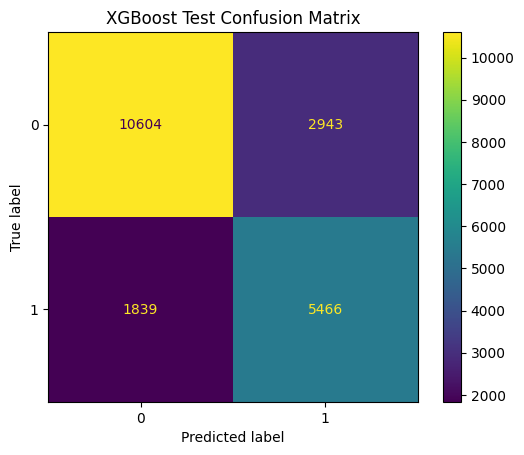

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Create display object with label names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

# Plot with formatting
fig, ax = plt.subplots()
disp.plot(cmap='viridis', ax=ax, values_format='d')  # 'd' forces integer format
plt.title("XGBoost Test Confusion Matrix")
plt.grid(False)
plt.show()


In [ ]:
# # Optuna hyperparameter tuning XGBoost
# def objective(trial):
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 100, 500),
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
#         "max_depth": trial.suggest_int("max_depth", 3, 10),
#         "subsample": trial.suggest_float("subsample", 0.7, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
#         "eval_metric": "auc",
#         "use_label_encoder": False,
#     }

#     model = XGBClassifier(**params)
#     score = cross_val_score(model, X_train, y_train, scoring="roc_auc", cv=3, n_jobs=-1)
#     return score.mean()

# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=10)

# print("Best trial:")
# print(study.best_trial.params)

## CatBoost

In [ ]:
# Count class distribution
counts = Counter(y_train)
num_negative = counts[0]
num_positive = counts[1]

# Inverse frequency method (scale by count)
weight_0 = 1.0
weight_1 = num_negative / num_positive

class_weights = [weight_0, weight_1]
print(f"Class weights: {class_weights}")

Class weights: [1.0, 1.8546073283069793]


In [ ]:
# Train CatBoost model
cat_model = CatBoostClassifier(
    iterations=800,
    learning_rate=0.01,
    depth=3,
    l2_leaf_reg=60,
    bagging_temperature=2.5,
    random_strength=3,
    subsample=0.7,
    grow_policy='Lossguide',
    early_stopping_rounds=100,
    use_best_model=True,
    eval_metric='AUC',
    class_weights=class_weights,
    random_seed=42,
    verbose=100
)

cat_model.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True)

# Predict probabilities
y_val_proba = cat_model.predict_proba(X_val)[:, 1]
y_test_proba = cat_model.predict_proba(X_test)[:, 1]

# Find optimal threshold (maximize F1 on validation)
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)

best_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\n Best Threshold (Validation F1): {optimal_threshold:.3f} (F1 = {best_f1:.4f})")

# Predict labels using optimal threshold
y_val_pred = (y_val_proba >= optimal_threshold).astype(int)
y_test_pred = (y_test_proba >= optimal_threshold).astype(int)

# Evaluation function
def evaluate(y_true, y_pred, y_proba, dataset='Validation'):
    print(f"\n {dataset} Performance (Threshold = {optimal_threshold:.3f}):")
    print(f"AUC       : {roc_auc_score(y_true, y_proba):.4f}")
    print(f"PR AUC    : {average_precision_score(y_true, y_proba):.4f}")
    print(f"Accuracy  : {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision : {precision_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"Recall    : {recall_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"F1-Score  : {f1_score(y_true, y_pred, zero_division=0):.4f}")

# Print results
evaluate(y_val, y_val_pred, y_val_proba, "Validation")
evaluate(y_test, y_test_pred, y_test_proba, "Test")


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7786340	best: 0.7786340 (0)	total: 76.6ms	remaining: 1m 1s
100:	test: 0.8302455	best: 0.8302455 (100)	total: 2.29s	remaining: 15.8s
200:	test: 0.8366800	best: 0.8366800 (200)	total: 4.49s	remaining: 13.4s
300:	test: 0.8395927	best: 0.8395927 (300)	total: 6.69s	remaining: 11.1s
400:	test: 0.8415081	best: 0.8415081 (400)	total: 9.04s	remaining: 9s
500:	test: 0.8430595	best: 0.8430595 (500)	total: 11.7s	remaining: 7s
600:	test: 0.8442630	best: 0.8442630 (600)	total: 14.1s	remaining: 4.66s
700:	test: 0.8454892	best: 0.8454892 (700)	total: 16.3s	remaining: 2.3s
799:	test: 0.8462462	best: 0.8462462 (799)	total: 18.6s	remaining: 0us

bestTest = 0.8462461851
bestIteration = 799


 Best Threshold (Validation F1): 0.506 (F1 = 0.7011)

 Validation Performance (Threshold = 0.506):
AUC       : 0.8462
PR AUC    : 0.7689
Accuracy  : 0.7753
Precision : 0.6564
Recall    : 0.7523
F1-Score  : 0.7011

 Test Performance (Threshold = 0.506):
AUC       : 0.8452
PR AUC    : 0.7678
Accuracy  : 0.770

### CatBoost Plots & Optuna tuning

0:	test: 0.7826171	test1: 0.7786340	best: 0.7786340 (0)	total: 29.6ms	remaining: 23.6s
100:	test: 0.8337998	test1: 0.8302455	best: 0.8302455 (100)	total: 2.82s	remaining: 19.5s
200:	test: 0.8403915	test1: 0.8366800	best: 0.8366800 (200)	total: 6.05s	remaining: 18s
300:	test: 0.8430265	test1: 0.8395927	best: 0.8395927 (300)	total: 9.08s	remaining: 15s
400:	test: 0.8448452	test1: 0.8415081	best: 0.8415081 (400)	total: 11.8s	remaining: 11.8s
500:	test: 0.8462213	test1: 0.8430595	best: 0.8430595 (500)	total: 14.6s	remaining: 8.72s
600:	test: 0.8472988	test1: 0.8442630	best: 0.8442630 (600)	total: 17.4s	remaining: 5.76s
700:	test: 0.8484502	test1: 0.8454892	best: 0.8454892 (700)	total: 20.8s	remaining: 2.94s
799:	test: 0.8491981	test1: 0.8462462	best: 0.8462462 (799)	total: 23.6s	remaining: 0us

bestTest = 0.8462461851
bestIteration = 799

Logged metric sets: dict_keys(['learn', 'validation_0', 'validation_1'])


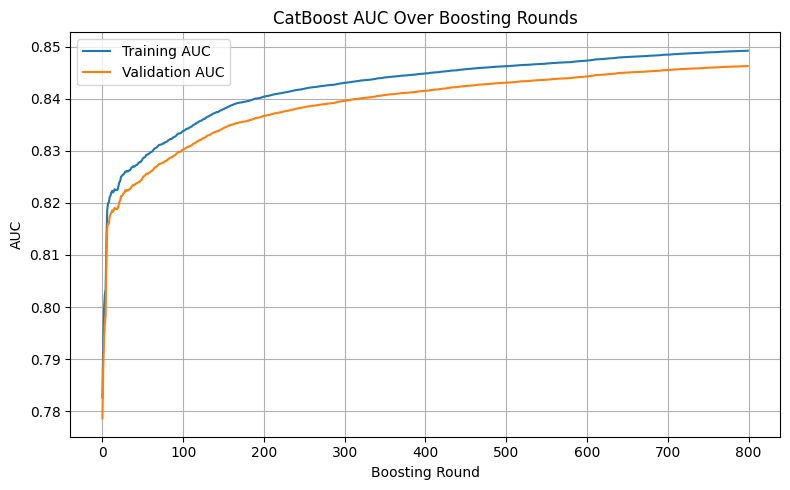

In [ ]:
# Define your train/validation sets
#  Order matters: first is 'validation_0', second is 'validation_1'
eval_set = [
    (X_train, y_train),  # validation_0 → training curve
    (X_val, y_val)                    # validation_1 → validation curve
]

# Fit the model with eval_set logging turned on
cat_model.fit(
    X_train, y_train,
    eval_set=eval_set,
    use_best_model=False
)

# Grab whatever keys CatBoost used for evals_result()
metrics = cat_model.get_evals_result()
print("Logged metric sets:", metrics.keys())
# e.g. dict_keys(['validation_0', 'validation_1'])

# Extract AUC lists
train_auc = metrics['validation_0']['AUC']
val_auc   = metrics['validation_1']['AUC']

# Plot
plt.figure(figsize=(8, 5))
plt.plot(train_auc, label='Training AUC')
plt.plot(val_auc,   label='Validation AUC')
plt.xlabel("Boosting Round")
plt.ylabel("AUC")
plt.title("CatBoost AUC Over Boosting Rounds")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

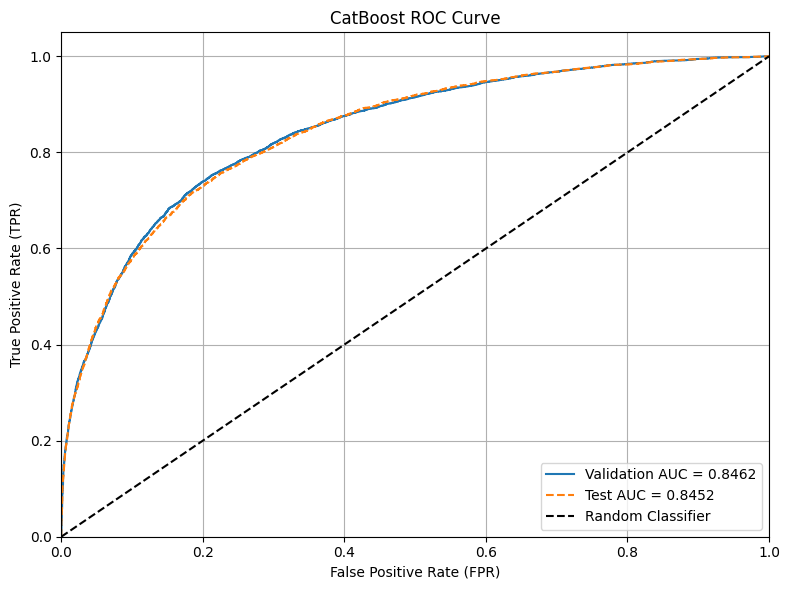

In [ ]:
# Plot ROC AUC Curve
def plot_roc_curve(y_true_val, y_proba_val, y_true_test, y_proba_test):
    fpr_val, tpr_val, _ = roc_curve(y_true_val, y_proba_val)
    auc_val = auc(fpr_val, tpr_val)

    fpr_test, tpr_test, _ = roc_curve(y_true_test, y_proba_test)
    auc_test = auc(fpr_test, tpr_test)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_val, tpr_val, label=f"Validation AUC = {auc_val:.4f}")
    plt.plot(fpr_test, tpr_test, label=f"Test AUC = {auc_test:.4f}", linestyle='--')
    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("CatBoost ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_roc_curve(y_val, y_val_proba, y_test, y_test_proba)

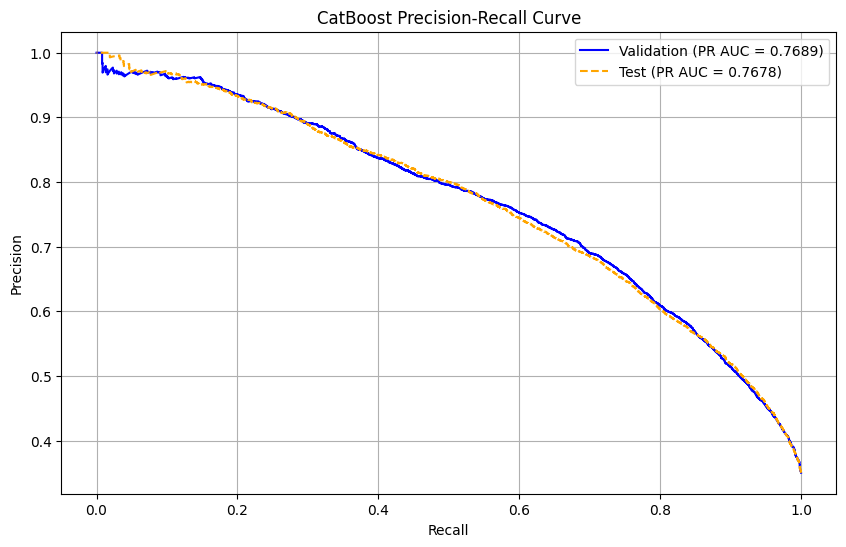

In [ ]:
# Get predicted probabilities
y_val_proba = cat_model.predict_proba(X_val)[:, 1]
y_test_proba = cat_model.predict_proba(X_test)[:, 1]

# Compute Precision-Recall curve
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_proba)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_proba)

# Compute PR AUC
pr_auc_val = average_precision_score(y_val, y_val_proba)
pr_auc_test = average_precision_score(y_test, y_test_proba)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(recall_val, precision_val, label=f'Validation (PR AUC = {pr_auc_val:.4f})', color='blue')
plt.plot(recall_test, precision_test, label=f'Test (PR AUC = {pr_auc_test:.4f})', color='orange', linestyle='--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('CatBoost Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


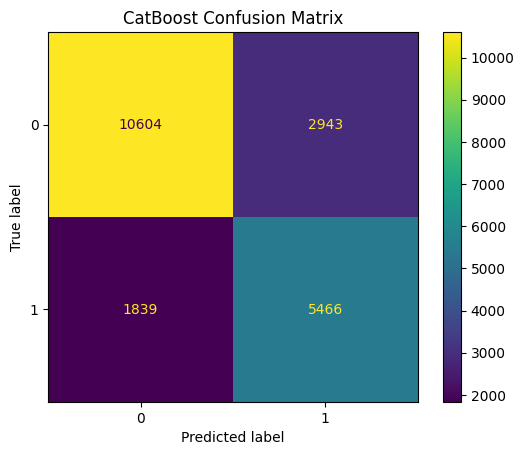

In [ ]:
# Generate confusion matrix for test set
cm = confusion_matrix(y_test, y_test_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='viridis')  # You can change cmap to 'Blues', 'plasma', etc.
plt.title("CatBoost Confusion Matrix")
plt.grid(False)
plt.show()

In [ ]:
# # Define Optuna Objective Function
# def objective(trial):
#     params = {
#         'iterations': trial.suggest_int('iterations', 100, 1000),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#         'depth': trial.suggest_int('depth', 4, 10),
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
#         'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
#         'border_count': trial.suggest_int('border_count', 32, 255),
#         'random_strength': trial.suggest_float('random_strength', 1e-9, 10.0),
#         'eval_metric': 'AUC',
#         'verbose': 0,
#         'random_seed': 42
#     }

#     model = CatBoostClassifier(**params)

#     # Optional: If you have categorical features, include them like this:
#     # cat_features = [index1, index2, ...]
#     # train_pool = Pool(X_train_bal, y_train_bal, cat_features=cat_features)
#     # scores = cross_val_score(model, train_pool, y_train_bal, scoring=make_scorer(roc_auc_score), cv=3)

#     scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=3)
#     return scores.mean()

# # Run optimization
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=10)

# # Print results
# print("Best parameters:")
# for key, val in study.best_trial.params.items():
#     print(f"{key}: {val}")
# print(f"\nBest AUC: {study.best_value:.4f}")

## Light Gradient Boosting

In [ ]:
# Clean up feature names
# ---------------------------
X_train.columns = X_train.columns.str.replace(r'[^\w\d_]+', '_', regex=True)
X_val.columns   = X_val.columns.str.replace(r'[^\w\d_]+', '_', regex=True)
X_test.columns  = X_test.columns.str.replace(r'[^\w\d_]+', '_', regex=True)

In [ ]:
# Compute class weight
n_pos = sum(y_train == 1)
n_neg = sum(y_train == 0)
scale_pos_weight = n_neg / max(1, n_pos)

print(f"Class balance — Neg: {n_neg}, Pos: {n_pos}, scale_pos_weight: {scale_pos_weight:.2f}")

Class balance — Neg: 63218, Pos: 34087, scale_pos_weight: 1.85


In [ ]:
# Prepare LightGBM datasets
lgb_train = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
lgb_val   = lgb.Dataset(X_val, label=y_val, reference=lgb_train, free_raw_data=False)

# LightGBM parameters
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.02,
    'num_leaves': 4,
    'max_depth': 2,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.6,
    'bagging_freq': 5,
    'min_data_in_leaf': 200,
    'lambda_l1': 5.0,
    'lambda_l2': 10.0,
    'extra_trees': True,
    'scale_pos_weight': scale_pos_weight,
    'verbosity': -1,
    'random_state': 42
}


# Train model
evals_result = {}  # define it

lgb_model = lgb.train(
    params,
    lgb_train,
    num_boost_round=300,
    valid_sets=[lgb_train, lgb_val],  # include both sets
    valid_names=['train', 'val'],
    callbacks=[
        lgb.record_evaluation(evals_result),
        lgb.early_stopping(stopping_rounds=30, verbose=True)
    ]
)



# Predict probabilities
y_val_pred_prob = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)
y_test_pred_prob = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

# Search best threshold on validation set
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []
for thresh in thresholds:
    preds = (y_val_pred_prob > thresh).astype(int)
    f1 = f1_score(y_val, preds, zero_division=0)
    f1_scores.append(f1)

best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\n Best threshold from validation set: {best_thresh:.2f} (F1: {best_f1:.4f})")

# Apply best threshold to val and test sets
y_val_pred_opt = (y_val_pred_prob > best_thresh).astype(int)
y_test_pred_opt = (y_test_pred_prob > best_thresh).astype(int)

# Define a function to print metrics
def print_metrics(name, y_true, y_pred, y_proba):
    print(f"\n {name} Set Metrics (Threshold = {best_thresh:.2f}):")
    print(f"ROC AUC     : {roc_auc_score(y_true, y_proba):.4f}")
    print(f"PR AUC      : {average_precision_score(y_true, y_proba):.4f}")
    print(f"Accuracy    : {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision   : {precision_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"Recall      : {recall_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"F1-Score    : {f1_score(y_true, y_pred, zero_division=0):.4f}")

# Print metrics for both sets
print_metrics("Validation", y_val, y_val_pred_opt, y_val_pred_prob)
print_metrics("Test", y_test, y_test_pred_opt, y_test_pred_prob)

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[300]	train's auc: 0.841196	val's auc: 0.837927

 Best threshold from validation set: 0.52 (F1: 0.6913)

 Validation Set Metrics (Threshold = 0.52):
ROC AUC     : 0.8379
PR AUC      : 0.7547
Accuracy    : 0.7732
Precision   : 0.6605
Recall      : 0.7251
F1-Score    : 0.6913

 Test Set Metrics (Threshold = 0.52):
ROC AUC     : 0.8388
PR AUC      : 0.7560
Accuracy    : 0.7707
Precision   : 0.6578
Recall      : 0.7202
F1-Score    : 0.6876


### LightGBM Plots & Optuna tuning

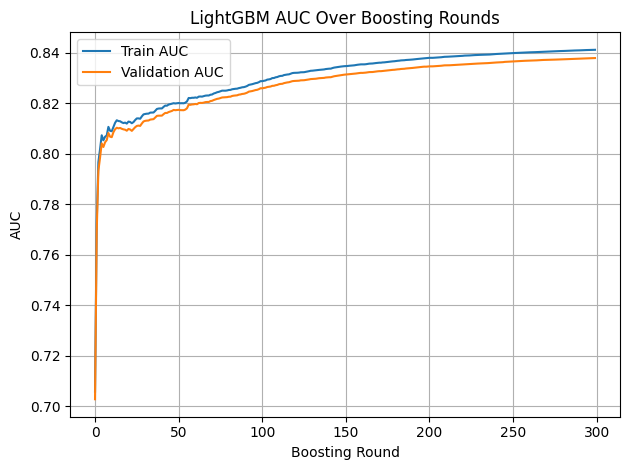

In [ ]:
# Plot AUC over Boosting Rounds
plt.plot(evals_result['train']['auc'], label='Train AUC')
plt.plot(evals_result['val']['auc'], label='Validation AUC')
plt.xlabel("Boosting Round")
plt.ylabel("AUC")
plt.title("LightGBM AUC Over Boosting Rounds")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


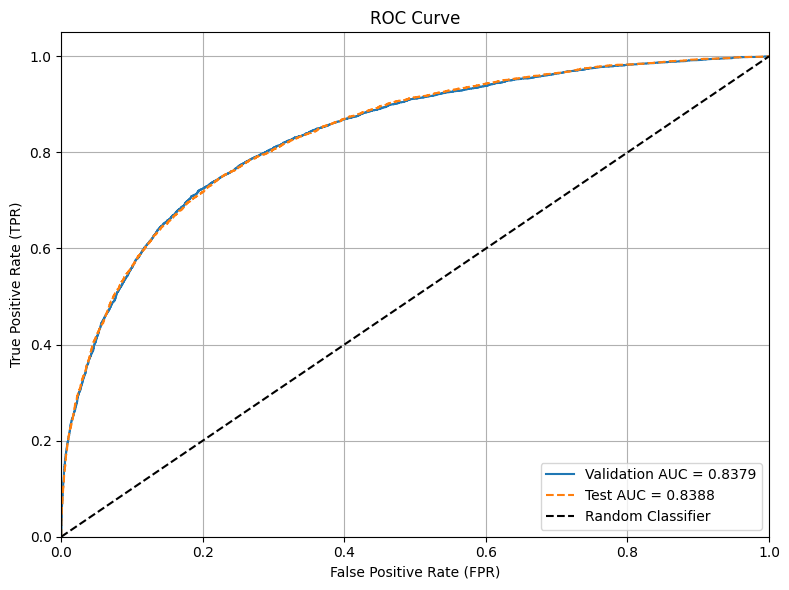

In [ ]:
# Plot AUC ROC Curve
def plot_roc_curve(y_true_val, y_proba_val, y_true_test, y_proba_test):
    # Compute ROC curve and AUC for Validation set
    fpr_val, tpr_val, _ = roc_curve(y_true_val, y_proba_val)
    auc_val = auc(fpr_val, tpr_val)

    # Compute ROC curve and AUC for Test set
    fpr_test, tpr_test, _ = roc_curve(y_true_test, y_proba_test)
    auc_test = auc(fpr_test, tpr_test)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_val, tpr_val, label=f"Validation AUC = {auc_val:.4f}")
    plt.plot(fpr_test, tpr_test, label=f"Test AUC = {auc_test:.4f}", linestyle='--')
    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_roc_curve(y_val, y_val_pred_prob, y_test, y_test_pred_prob)

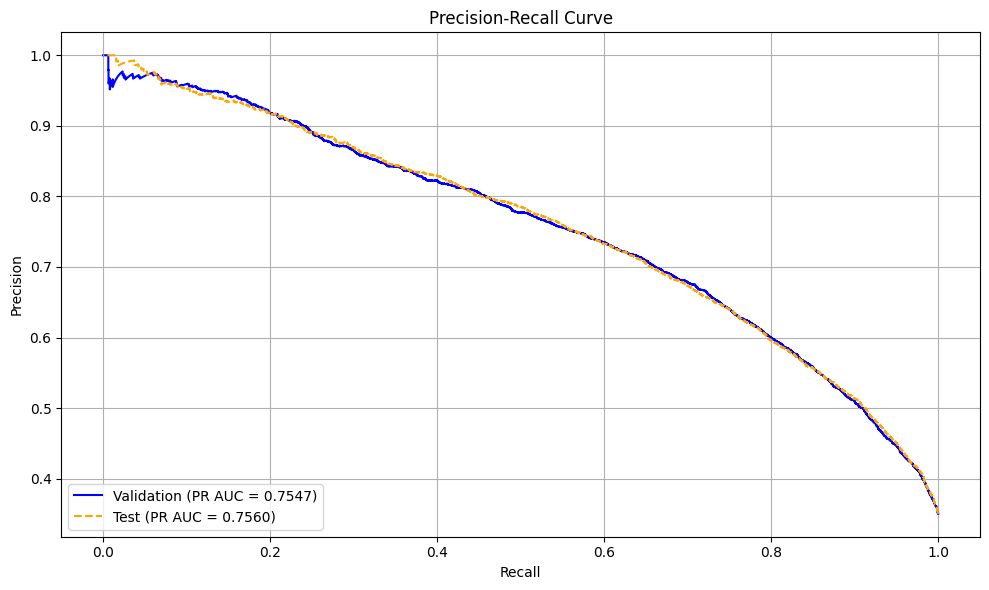

In [ ]:
# Plot Precision-Recall Curve
# LightGBM: Predict probabilities
y_val_proba = lgb_model.predict(X_val)
y_test_proba = lgb_model.predict(X_test)

# Compute precision-recall curve
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_proba)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_proba)

# Compute average precision score (PR AUC)
pr_auc_val = average_precision_score(y_val, y_val_proba)
pr_auc_test = average_precision_score(y_test, y_test_proba)

# Plot PR Curve
plt.figure(figsize=(10, 6))
plt.plot(recall_val, precision_val, label=f'Validation (PR AUC = {pr_auc_val:.4f})', color='blue')
plt.plot(recall_test, precision_test, label=f'Test (PR AUC = {pr_auc_test:.4f})', color='orange', linestyle='--')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()


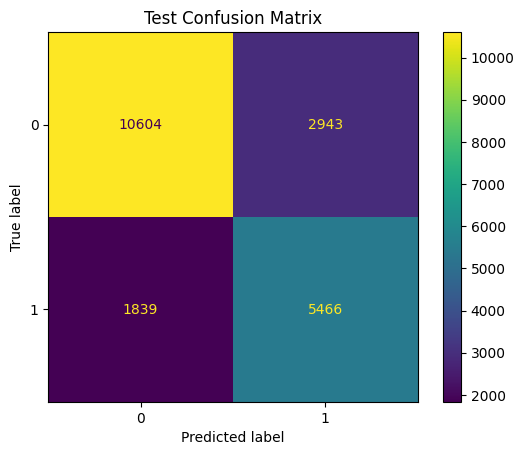

In [ ]:
# Generate confusion matrix for test set
cm = confusion_matrix(y_test, y_test_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='viridis')  # You can change cmap to 'Blues', 'plasma', etc.
plt.title("Test Confusion Matrix")
plt.grid(False)
plt.show()

In [ ]:
# import optuna
# import lightgbm as lgb
# from sklearn.metrics import roc_auc_score

# def make_objective(X_valid, y_valid, lgb_train, scale_pos_weight):
#     def objective(trial):
#         param = {
#             'objective': 'binary',
#             'metric': 'auc',
#             'boosting_type': 'gbdt',
#             'verbosity': -1,
#             'random_state': 42,
#             'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
#             'num_leaves': trial.suggest_int('num_leaves', 20, 150),
#             'max_depth': trial.suggest_int('max_depth', 3, 12),
#             'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#             'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#             'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#             'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 5.0),
#             'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 5.0),
#             'scale_pos_weight': scale_pos_weight  #  for class imbalance
#         }

#         gbm = lgb.train(
#             param,
#             lgb_train,
#             valid_sets=[lgb_train],
#             valid_names=["train"],
#             num_boost_round=1000,
#         )

#         preds = gbm.predict(X_valid)
#         auc = roc_auc_score(y_valid, preds)
#         return auc
#     return objective


# study = optuna.create_study(direction='maximize')
# study.optimize(make_objective(X_val, y_val, lgb_train, scale_pos_weight), n_trials=50, timeout=1200)

# print("\n Best AUC:", study.best_value)
# print(" Best Params:")
# for k, v in study.best_params.items():
#     print(f" - {k}: {v}")

In [ ]:
# # Objective function for Optuna
# def objective(trial):
#     param = {
#         'objective': 'binary',
#         'metric': 'auc',
#         'boosting_type': 'gbdt',
#         'verbosity': -1,
#         'random_state': 42,
#         'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
#         'num_leaves': trial.suggest_int('num_leaves', 20, 150),
#         'max_depth': trial.suggest_int('max_depth', 3, 12),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 5.0),
#         'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 5.0),
#         'scale_pos_weight': scale_pos_weight  #  Adjust for class imbalance
#     }

#     lgb_model = lgb.train(
#         param,
#         lgb_train,
#         valid_sets=[lgb_train],
#         valid_names=["val"],
#         num_boost_round=1000,
#     )

#     preds = lgb_model.predict(X_valid)
#     auc = roc_auc_score(y_valid, preds)
#     return auc

# # Run Optuna
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50, timeout=1200)  # 50 trials or 20 mins

# # Best params and score
# print(" Best AUC:", study.best_value)
# print(" Best Params:")
# for k, v in study.best_params.items():
#     print(f"  {k}: {v}")

# Explainable AI (XAI) using SHAP

/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/tmp/ipython-input-97-2751029118.py:10: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_val, plot_type="bar")


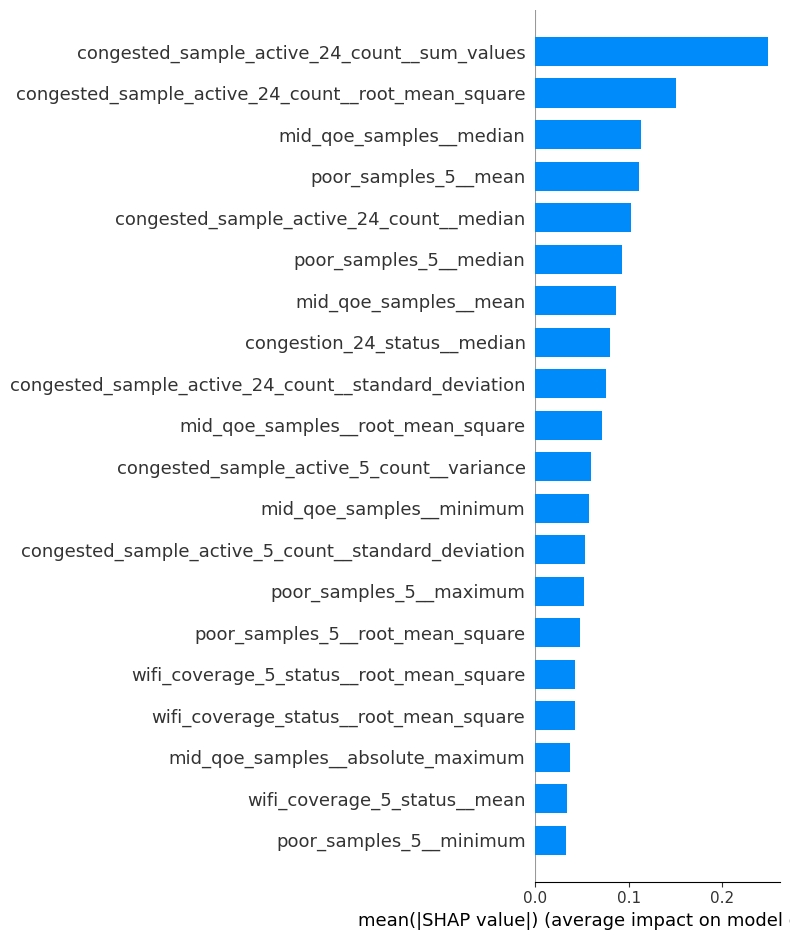

/tmp/ipython-input-97-2751029118.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_val)


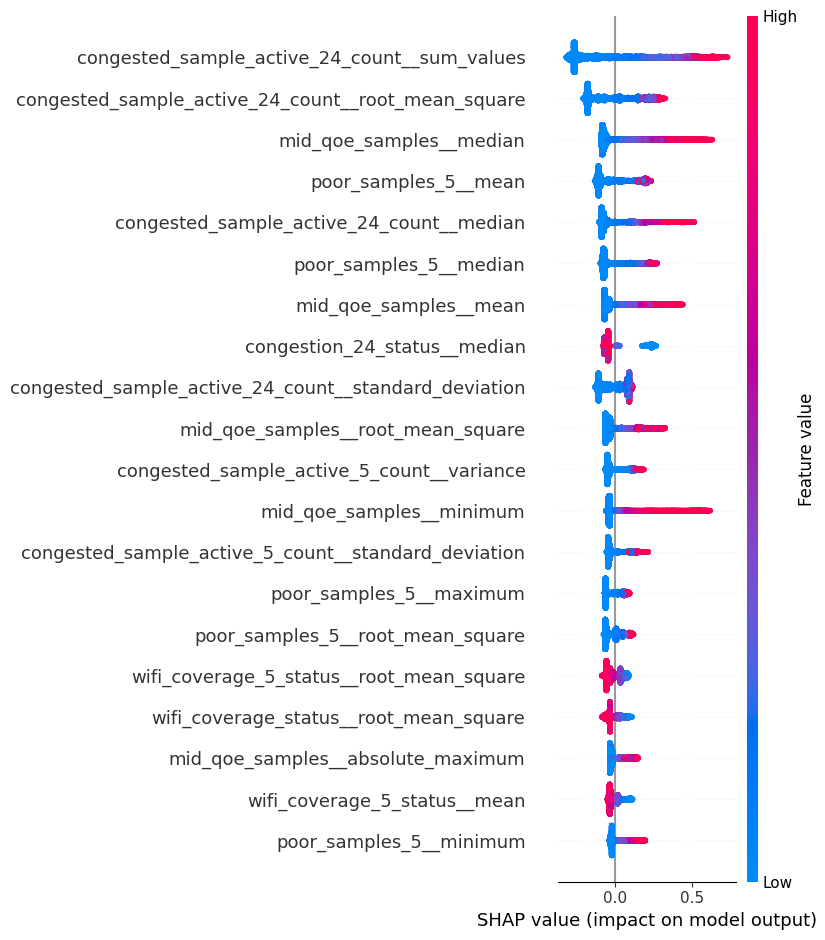

/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


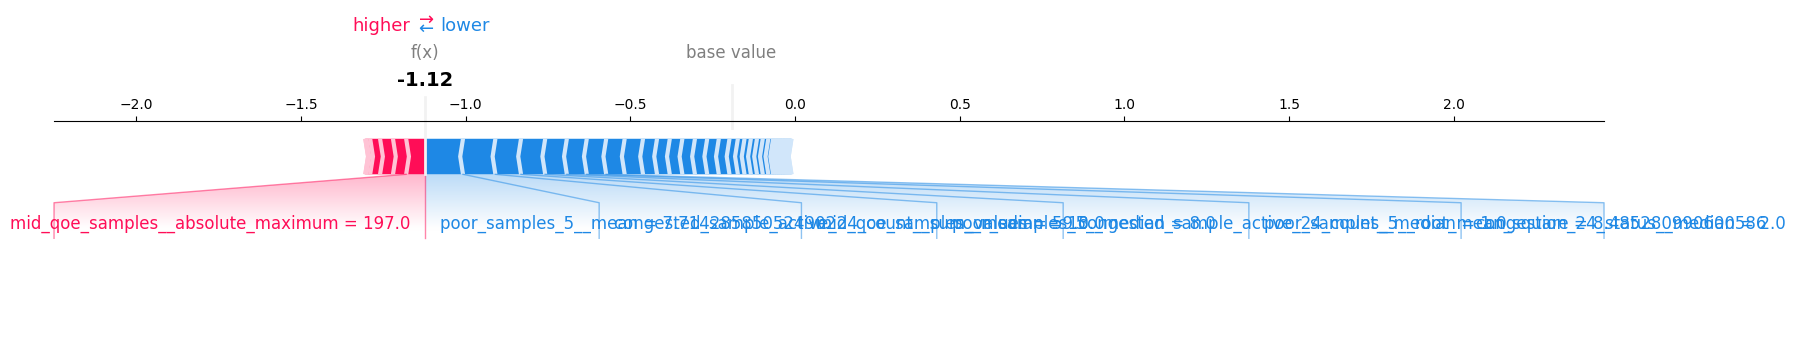

In [ ]:
import shap

# Initialize SHAP TreeExplainer with LightGBM model
explainer = shap.TreeExplainer(lgb_model)

# Compute SHAP values for the validation set
shap_values = explainer.shap_values(X_val)

# Optional: summary plot of feature importance
shap.summary_plot(shap_values, X_val, plot_type="bar")

# Optional: full SHAP summary with violin plot
shap.summary_plot(shap_values, X_val)

# Explain one instance from validation set
row_idx = 6
X_single = X_val.iloc[[row_idx]]
shap_single = explainer.shap_values(X_single)

# Force plot for a single prediction (class 1)
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_single,
    X_single,
    matplotlib=True  # or use False for JS-based output
)


Device ID       : unknown
True Label      : 1
Predicted Label : 1
Predicted Prob. : 1.0000


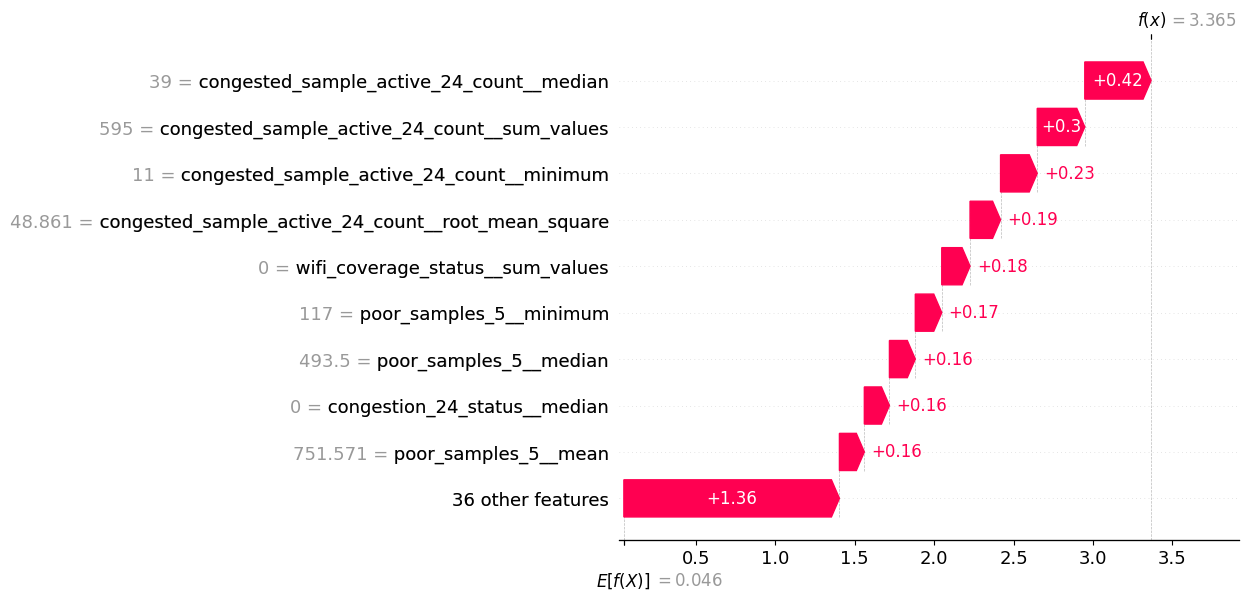

In [ ]:
import shap

# Select a row to explain ---
row_idx = 27  # Change this to the index you want to inspect
X_single = X_val.iloc[[row_idx]]
y_true = y_val.iloc[row_idx]
y_proba = cat_model.predict(X_single)[0]
y_pred_label = int(y_proba >= 0.5)

# Show device ID
device_id = X_single['device_id'].values[0] if 'device_id' in X_single.columns else 'unknown'
print(f"Device ID       : {device_id}")
print(f"True Label      : {y_true}")
print(f"Predicted Label : {y_pred_label}")
print(f"Predicted Prob. : {y_proba:.4f}")

# SHAP Explainer for LightGBM
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer(X_single)

# Waterfall Plot
shap.plots.waterfall(shap_values[0], max_display=10)


Device ID       : unknown
True Label      : 0
Predicted Label : 0
Predicted Prob. : 0.4441


/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


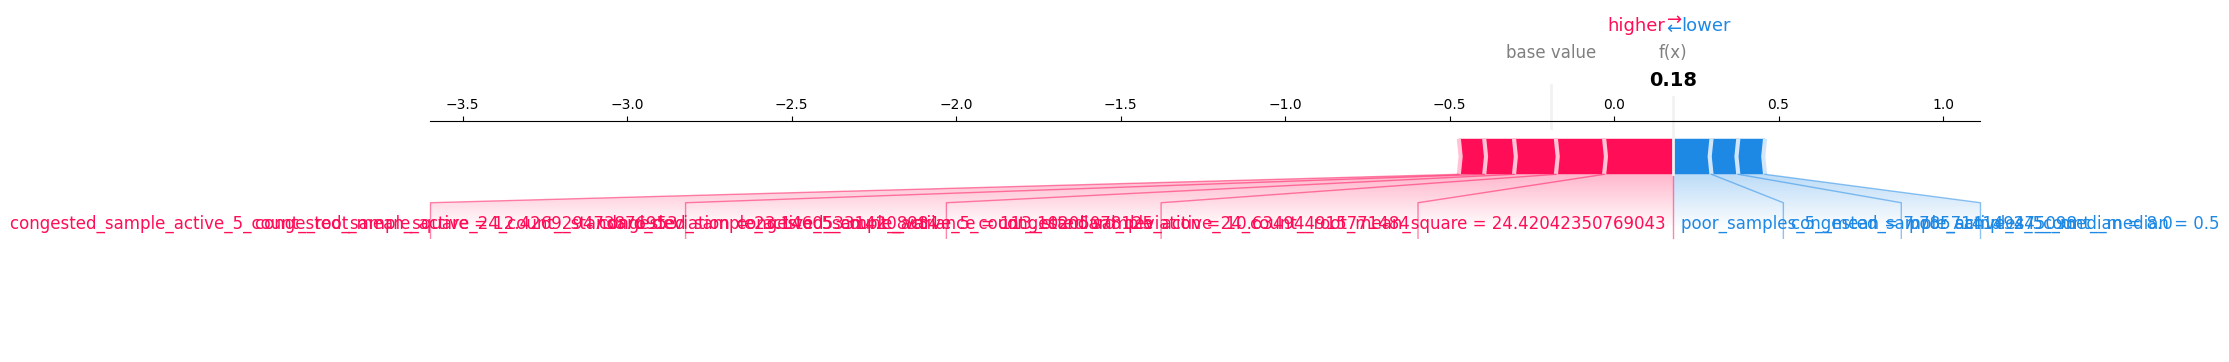

In [ ]:
import shap
import matplotlib.pyplot as plt

# === Select row to explain ===
row_idx = 17
X_single = X_val.iloc[[row_idx]]
y_true = y_val.iloc[row_idx]
device_id = X_single['device_id'] if 'device_id' in X_single.columns else 'unknown'

# === Predict ===
y_proba = lgb_model.predict(X_single)[0]
y_pred_label = int(y_proba >= 0.5)

print(f"Device ID       : {device_id}")
print(f"True Label      : {y_true}")
print(f"Predicted Label : {y_pred_label}")
print(f"Predicted Prob. : {y_proba:.4f}")

# === SHAP Explanation ===
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_single)

# === Simplified force plot (Top N features only) ===
top_n = 8
shap_values_array = shap_values[0] if isinstance(shap_values, list) else shap_values
abs_shap = np.abs(shap_values_array).flatten()
top_idx = abs_shap.argsort()[::-1][:top_n]

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[0] if isinstance(explainer.expected_value, list) else explainer.expected_value,
    shap_values=shap_values_array[:, top_idx],
    features=X_single.iloc[0, top_idx],
    feature_names=X_single.columns[top_idx],
    matplotlib=True
)
